In [14]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [15]:

p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [16]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [17]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

In [18]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [19]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 170795


In [20]:
pbp_data.distance = pbp_data.distance.astype(float)
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety","placeholder","End of Period"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [21]:
# %%timeit
if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep, axis=1)

In [22]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,27,72,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449
5,5,322430009006,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,56,56,1,10.0,16,Pass Completion,Taylor Kelly pass complete to Richard Smith fo...,0.648868,2012,1.087793


In [23]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [84]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_special_teams_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types)) & (pbp.offense == team)]
    fg_plays = st_plays[st_plays.play_type.str.contains('Field Goal')]
    kickoff_plays = st_plays[st_plays.play_type.str.contains('Kickoff')]
    punt_plays = st_plays[st_plays.play_type.str.contains('Punt')]
    
    fg_eff = verify_division(fg_plays[fg_plays.play_type.str.contains('Good')], len(fg_plays))
    #kick_returns = kickoff_plays[kickoff_plays.play_type.str.contains("Return")]
    # regex for kickoff air yards "kickoff for /d yds"
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
#         'PuntSR': [],
#         'KickoffSR': []
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.IsoPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,3)
    # return translate(team_stat_pack.OppSRDiff, -1, 1, 0, ((5.83 + 3.38)/2.0)) + translate(team_stat_pack.IsoPPPDiff, -1, 1, 0, ((4.17+4.41)/2.0)) + translate(team_stat_pack.OffSRDiff, -1, 1, 0, ((4.17+2.21)/2))

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.05 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: ep_data.iloc[min(100, (x.yard_line + x.yards_gained))].ep - ep_data.iloc[x.yard_line].ep, axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,4.833875,0.167751
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.666125,-0.167751


In [85]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if ('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv")):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    if (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
    stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
    print(f"[Local] Grouping box score rows by GameID...")
    groups = stored_game_boxes.groupby('GameID')
    print(f"[Local] Generated {len(groups)} box score groups by GameID.")
    current = 0
    for (name, group) in groups:
        print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
        group_ratings = group['5FR']
        top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
        bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
        group['5FRDiff'] = [top_diff, bot_diff]
        print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
        current+=1
    print(f"[Local] Finished updating box scores with new 5FR margins.")
print(f"[Local] Writing updated box scores to file...")
stored_game_boxes.to_csv("results/box-scores.csv", sep=",")
print(f"[Local] Wrote updated box scores to file.")

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 5670 box score groups by GameID.
[1/5670] Updating 5FR Margin for game_id 322430041...
[1/5670] Updated 5FR Margin for game_id 322430041.
[2/5670] Updating 5FR Margin for game_id 322430238...
[2/5670] Updated 5FR Margin for game_id 322430238.
[3/5670] Updating 5FR Margin for game_id 322430242...


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[3/5670] Updated 5FR Margin for game_id 322430242.
[4/5670] Updating 5FR Margin for game_id 322430252...
[4/5670] Updated 5FR Margin for game_id 322430252.
[5/5670] Updating 5FR Margin for game_id 322432006...
[5/5670] Updated 5FR Margin for game_id 322432006.
[6/5670] Updating 5FR Margin for game_id 322432050...
[6/5670] Updated 5FR Margin for game_id 322432050.
[7/5670] Updating 5FR Margin for game_id 322432439...
[7/5670] Updated 5FR Margin for game_id 322432439.
[8/5670] Updating 5FR Margin for game_id 322440024...
[8/5670] Updated 5FR Margin for game_id 322440024.
[9/5670] Updating 5FR Margin for game_id 322440127...
[9/5670] Updated 5FR Margin for game_id 322440127.
[10/5670] Updating 5FR Margin for game_id 322442633...
[10/5670] Updated 5FR Margin for game_id 322442633.
[11/5670] Updating 5FR Margin for game_id 322450002...
[11/5670] Updated 5FR Margin for game_id 322450002.
[12/5670] Updating 5FR Margin for game_id 322450005...
[12/5670] Updated 5FR Margin for game_id 322450005

[80/5670] Updated 5FR Margin for game_id 322522393.
[81/5670] Updating 5FR Margin for game_id 322522440...
[81/5670] Updated 5FR Margin for game_id 322522440.
[82/5670] Updating 5FR Margin for game_id 322522483...
[82/5670] Updated 5FR Margin for game_id 322522483.
[83/5670] Updating 5FR Margin for game_id 322522579...
[83/5670] Updated 5FR Margin for game_id 322522579.
[84/5670] Updating 5FR Margin for game_id 322522633...
[84/5670] Updated 5FR Margin for game_id 322522633.
[85/5670] Updating 5FR Margin for game_id 322522653...
[85/5670] Updated 5FR Margin for game_id 322522653.
[86/5670] Updating 5FR Margin for game_id 322522751...
[86/5670] Updated 5FR Margin for game_id 322522751.
[87/5670] Updating 5FR Margin for game_id 322570058...
[87/5670] Updated 5FR Margin for game_id 322570058.
[88/5670] Updating 5FR Margin for game_id 322582439...
[88/5670] Updated 5FR Margin for game_id 322582439.
[89/5670] Updating 5FR Margin for game_id 322590002...
[89/5670] Updated 5FR Margin for game

[161/5670] Updated 5FR Margin for game_id 322660249.
[162/5670] Updating 5FR Margin for game_id 322660259...
[162/5670] Updated 5FR Margin for game_id 322660259.
[163/5670] Updating 5FR Margin for game_id 322660265...
[163/5670] Updated 5FR Margin for game_id 322660265.
[164/5670] Updating 5FR Margin for game_id 322660275...
[164/5670] Updated 5FR Margin for game_id 322660275.
[165/5670] Updating 5FR Margin for game_id 322660277...
[165/5670] Updated 5FR Margin for game_id 322660277.
[166/5670] Updating 5FR Margin for game_id 322660333...
[166/5670] Updated 5FR Margin for game_id 322660333.
[167/5670] Updating 5FR Margin for game_id 322660344...
[167/5670] Updated 5FR Margin for game_id 322660344.
[168/5670] Updating 5FR Margin for game_id 322660356...
[168/5670] Updated 5FR Margin for game_id 322660356.
[169/5670] Updating 5FR Margin for game_id 322662050...
[169/5670] Updated 5FR Margin for game_id 322662050.
[170/5670] Updating 5FR Margin for game_id 322662229...
[170/5670] Updated 

[240/5670] Updated 5FR Margin for game_id 322800096.
[241/5670] Updating 5FR Margin for game_id 322800120...
[241/5670] Updated 5FR Margin for game_id 322800120.
[242/5670] Updating 5FR Margin for game_id 322800142...
[242/5670] Updated 5FR Margin for game_id 322800142.
[243/5670] Updating 5FR Margin for game_id 322800145...
[243/5670] Updated 5FR Margin for game_id 322800145.
[244/5670] Updating 5FR Margin for game_id 322800150...
[244/5670] Updated 5FR Margin for game_id 322800150.
[245/5670] Updating 5FR Margin for game_id 322800152...
[245/5670] Updated 5FR Margin for game_id 322800152.
[246/5670] Updating 5FR Margin for game_id 322800153...
[246/5670] Updated 5FR Margin for game_id 322800153.
[247/5670] Updating 5FR Margin for game_id 322800164...
[247/5670] Updated 5FR Margin for game_id 322800164.
[248/5670] Updating 5FR Margin for game_id 322800167...
[248/5670] Updated 5FR Margin for game_id 322800167.
[249/5670] Updating 5FR Margin for game_id 322800194...
[249/5670] Updated 

[321/5670] Updated 5FR Margin for game_id 322872229.
[322/5670] Updating 5FR Margin for game_id 322872305...
[322/5670] Updated 5FR Margin for game_id 322872305.
[323/5670] Updating 5FR Margin for game_id 322872348...
[323/5670] Updated 5FR Margin for game_id 322872348.
[324/5670] Updating 5FR Margin for game_id 322872390...
[324/5670] Updated 5FR Margin for game_id 322872390.
[325/5670] Updating 5FR Margin for game_id 322872433...
[325/5670] Updated 5FR Margin for game_id 322872433.
[326/5670] Updating 5FR Margin for game_id 322872439...
[326/5670] Updated 5FR Margin for game_id 322872439.
[327/5670] Updating 5FR Margin for game_id 322872459...
[327/5670] Updated 5FR Margin for game_id 322872459.
[328/5670] Updating 5FR Margin for game_id 322872509...
[328/5670] Updated 5FR Margin for game_id 322872509.
[329/5670] Updating 5FR Margin for game_id 322872641...
[329/5670] Updated 5FR Margin for game_id 322872641.
[330/5670] Updating 5FR Margin for game_id 322872751...
[330/5670] Updated 

[401/5670] Updated 5FR Margin for game_id 323010061.
[402/5670] Updating 5FR Margin for game_id 323010066...
[402/5670] Updated 5FR Margin for game_id 323010066.
[403/5670] Updating 5FR Margin for game_id 323010077...
[403/5670] Updated 5FR Margin for game_id 323010077.
[404/5670] Updating 5FR Margin for game_id 323010103...
[404/5670] Updated 5FR Margin for game_id 323010103.
[405/5670] Updating 5FR Margin for game_id 323010135...
[405/5670] Updated 5FR Margin for game_id 323010135.
[406/5670] Updating 5FR Margin for game_id 323010142...
[406/5670] Updated 5FR Margin for game_id 323010142.
[407/5670] Updating 5FR Margin for game_id 323010151...
[407/5670] Updated 5FR Margin for game_id 323010151.
[408/5670] Updating 5FR Margin for game_id 323010153...
[408/5670] Updated 5FR Margin for game_id 323010153.
[409/5670] Updating 5FR Margin for game_id 323010158...
[409/5670] Updated 5FR Margin for game_id 323010158.
[410/5670] Updating 5FR Margin for game_id 323010164...
[410/5670] Updated 

[485/5670] Updated 5FR Margin for game_id 323082132.
[486/5670] Updating 5FR Margin for game_id 323082306...
[486/5670] Updated 5FR Margin for game_id 323082306.
[487/5670] Updating 5FR Margin for game_id 323082309...
[487/5670] Updated 5FR Margin for game_id 323082309.
[488/5670] Updating 5FR Margin for game_id 323082348...
[488/5670] Updated 5FR Margin for game_id 323082348.
[489/5670] Updating 5FR Margin for game_id 323082426...
[489/5670] Updated 5FR Margin for game_id 323082426.
[490/5670] Updating 5FR Margin for game_id 323082433...
[490/5670] Updated 5FR Margin for game_id 323082433.
[491/5670] Updating 5FR Margin for game_id 323082439...
[491/5670] Updated 5FR Margin for game_id 323082439.
[492/5670] Updating 5FR Margin for game_id 323082459...
[492/5670] Updated 5FR Margin for game_id 323082459.
[493/5670] Updating 5FR Margin for game_id 323082509...
[493/5670] Updated 5FR Margin for game_id 323082509.
[494/5670] Updating 5FR Margin for game_id 323082572...
[494/5670] Updated 

[563/5670] Updated 5FR Margin for game_id 323220038.
[564/5670] Updating 5FR Margin for game_id 323220059...
[564/5670] Updated 5FR Margin for game_id 323220059.
[565/5670] Updating 5FR Margin for game_id 323220061...
[565/5670] Updated 5FR Margin for game_id 323220061.
[566/5670] Updating 5FR Margin for game_id 323220068...
[566/5670] Updated 5FR Margin for game_id 323220068.
[567/5670] Updating 5FR Margin for game_id 323220087...
[567/5670] Updated 5FR Margin for game_id 323220087.
[568/5670] Updating 5FR Margin for game_id 323220099...
[568/5670] Updated 5FR Margin for game_id 323220099.
[569/5670] Updating 5FR Margin for game_id 323220103...
[569/5670] Updated 5FR Margin for game_id 323220103.
[570/5670] Updating 5FR Margin for game_id 323220120...
[570/5670] Updated 5FR Margin for game_id 323220120.
[571/5670] Updating 5FR Margin for game_id 323220127...
[571/5670] Updated 5FR Margin for game_id 323220127.
[572/5670] Updating 5FR Margin for game_id 323220130...
[572/5670] Updated 

[644/5670] Updated 5FR Margin for game_id 323290228.
[645/5670] Updating 5FR Margin for game_id 323290235...
[645/5670] Updated 5FR Margin for game_id 323290235.
[646/5670] Updating 5FR Margin for game_id 323290245...
[646/5670] Updated 5FR Margin for game_id 323290245.
[647/5670] Updating 5FR Margin for game_id 323290248...
[647/5670] Updated 5FR Margin for game_id 323290248.
[648/5670] Updating 5FR Margin for game_id 323290259...
[648/5670] Updated 5FR Margin for game_id 323290259.
[649/5670] Updating 5FR Margin for game_id 323290278...
[649/5670] Updated 5FR Margin for game_id 323290278.
[650/5670] Updating 5FR Margin for game_id 323290309...
[650/5670] Updated 5FR Margin for game_id 323290309.
[651/5670] Updating 5FR Margin for game_id 323290333...
[651/5670] Updated 5FR Margin for game_id 323290333.
[652/5670] Updating 5FR Margin for game_id 323292116...
[652/5670] Updated 5FR Margin for game_id 323292116.
[653/5670] Updating 5FR Margin for game_id 323292229...
[653/5670] Updated 

[724/5670] Updated 5FR Margin for game_id 332440097.
[725/5670] Updating 5FR Margin for game_id 332450221...
[725/5670] Updated 5FR Margin for game_id 332450221.
[726/5670] Updating 5FR Margin for game_id 332480151...
[726/5670] Updated 5FR Margin for game_id 332480151.
[727/5670] Updating 5FR Margin for game_id 332490103...
[727/5670] Updated 5FR Margin for game_id 332490103.
[728/5670] Updating 5FR Margin for game_id 332492229...
[728/5670] Updated 5FR Margin for game_id 332492229.
[729/5670] Updating 5FR Margin for game_id 332500002...
[729/5670] Updated 5FR Margin for game_id 332500002.
[730/5670] Updating 5FR Margin for game_id 332500024...
[730/5670] Updated 5FR Margin for game_id 332500024.
[731/5670] Updating 5FR Margin for game_id 332500030...
[731/5670] Updated 5FR Margin for game_id 332500030.
[732/5670] Updating 5FR Margin for game_id 332500061...
[732/5670] Updated 5FR Margin for game_id 332500061.
[733/5670] Updating 5FR Margin for game_id 332500077...
[733/5670] Updated 

[802/5670] Updated 5FR Margin for game_id 332570349.
[803/5670] Updating 5FR Margin for game_id 332570356...
[803/5670] Updated 5FR Margin for game_id 332570356.
[804/5670] Updating 5FR Margin for game_id 332572306...
[804/5670] Updated 5FR Margin for game_id 332572306.
[805/5670] Updating 5FR Margin for game_id 332572393...
[805/5670] Updated 5FR Margin for game_id 332572393.
[806/5670] Updating 5FR Margin for game_id 332572439...
[806/5670] Updated 5FR Margin for game_id 332572439.
[807/5670] Updating 5FR Margin for game_id 332572483...
[807/5670] Updated 5FR Margin for game_id 332572483.
[808/5670] Updating 5FR Margin for game_id 332572509...
[808/5670] Updated 5FR Margin for game_id 332572509.
[809/5670] Updating 5FR Margin for game_id 332572579...
[809/5670] Updated 5FR Margin for game_id 332572579.
[810/5670] Updating 5FR Margin for game_id 332620152...
[810/5670] Updated 5FR Margin for game_id 332620152.
[811/5670] Updating 5FR Margin for game_id 332630278...
[811/5670] Updated 

[883/5670] Updated 5FR Margin for game_id 332710265.
[884/5670] Updating 5FR Margin for game_id 332710277...
[884/5670] Updated 5FR Margin for game_id 332710277.
[885/5670] Updating 5FR Margin for game_id 332710326...
[885/5670] Updated 5FR Margin for game_id 332710326.
[886/5670] Updating 5FR Margin for game_id 332710333...
[886/5670] Updated 5FR Margin for game_id 332710333.
[887/5670] Updating 5FR Margin for game_id 332710356...
[887/5670] Updated 5FR Margin for game_id 332710356.
[888/5670] Updating 5FR Margin for game_id 332712050...
[888/5670] Updated 5FR Margin for game_id 332712050.
[889/5670] Updating 5FR Margin for game_id 332712084...
[889/5670] Updated 5FR Margin for game_id 332712084.
[890/5670] Updating 5FR Margin for game_id 332712116...
[890/5670] Updated 5FR Margin for game_id 332712116.
[891/5670] Updating 5FR Margin for game_id 332712348...
[891/5670] Updated 5FR Margin for game_id 332712348.
[892/5670] Updating 5FR Margin for game_id 332712433...
[892/5670] Updated 

[967/5670] Updated 5FR Margin for game_id 332850113.
[968/5670] Updating 5FR Margin for game_id 332850120...
[968/5670] Updated 5FR Margin for game_id 332850120.
[969/5670] Updating 5FR Margin for game_id 332850127...
[969/5670] Updated 5FR Margin for game_id 332850127.
[970/5670] Updating 5FR Margin for game_id 332850145...
[970/5670] Updated 5FR Margin for game_id 332850145.
[971/5670] Updating 5FR Margin for game_id 332850150...
[971/5670] Updated 5FR Margin for game_id 332850150.
[972/5670] Updating 5FR Margin for game_id 332850152...
[972/5670] Updated 5FR Margin for game_id 332850152.
[973/5670] Updating 5FR Margin for game_id 332850195...
[973/5670] Updated 5FR Margin for game_id 332850195.
[974/5670] Updating 5FR Margin for game_id 332850213...
[974/5670] Updated 5FR Margin for game_id 332850213.
[975/5670] Updating 5FR Margin for game_id 332850228...
[975/5670] Updated 5FR Margin for game_id 332850228.
[976/5670] Updating 5FR Margin for game_id 332850248...
[976/5670] Updated 

[1047/5670] Updated 5FR Margin for game_id 332922483.
[1048/5670] Updating 5FR Margin for game_id 332922633...
[1048/5670] Updated 5FR Margin for game_id 332922633.
[1049/5670] Updating 5FR Margin for game_id 332922649...
[1049/5670] Updated 5FR Margin for game_id 332922649.
[1050/5670] Updating 5FR Margin for game_id 332922711...
[1050/5670] Updated 5FR Margin for game_id 332922711.
[1051/5670] Updating 5FR Margin for game_id 332922751...
[1051/5670] Updated 5FR Margin for game_id 332922751.
[1052/5670] Updating 5FR Margin for game_id 332952032...
[1052/5670] Updated 5FR Margin for game_id 332952032.
[1053/5670] Updating 5FR Margin for game_id 332970344...
[1053/5670] Updated 5FR Margin for game_id 332970344.
[1054/5670] Updating 5FR Margin for game_id 332972393...
[1054/5670] Updated 5FR Margin for game_id 332972393.
[1055/5670] Updating 5FR Margin for game_id 332980252...
[1055/5670] Updated 5FR Margin for game_id 332980252.
[1056/5670] Updating 5FR Margin for game_id 332990002...
[

[1122/5670] Updated 5FR Margin for game_id 333060103.
[1123/5670] Updating 5FR Margin for game_id 333060113...
[1123/5670] Updated 5FR Margin for game_id 333060113.
[1124/5670] Updating 5FR Margin for game_id 333060127...
[1124/5670] Updated 5FR Margin for game_id 333060127.
[1125/5670] Updating 5FR Margin for game_id 333060142...
[1125/5670] Updated 5FR Margin for game_id 333060142.
[1126/5670] Updating 5FR Margin for game_id 333060152...
[1126/5670] Updated 5FR Margin for game_id 333060152.
[1127/5670] Updating 5FR Margin for game_id 333060158...
[1127/5670] Updated 5FR Margin for game_id 333060158.
[1128/5670] Updating 5FR Margin for game_id 333060164...
[1128/5670] Updated 5FR Margin for game_id 333060164.
[1129/5670] Updating 5FR Margin for game_id 333060183...
[1129/5670] Updated 5FR Margin for game_id 333060183.
[1130/5670] Updating 5FR Margin for game_id 333060202...
[1130/5670] Updated 5FR Margin for game_id 333060202.
[1131/5670] Updating 5FR Margin for game_id 333060213...
[

[1203/5670] Updated 5FR Margin for game_id 333160189.
[1204/5670] Updating 5FR Margin for game_id 333162649...
[1204/5670] Updated 5FR Margin for game_id 333162649.
[1205/5670] Updating 5FR Margin for game_id 333172309...
[1205/5670] Updated 5FR Margin for game_id 333172309.
[1206/5670] Updating 5FR Margin for game_id 333172459...
[1206/5670] Updated 5FR Margin for game_id 333172459.
[1207/5670] Updating 5FR Margin for game_id 333180202...
[1207/5670] Updated 5FR Margin for game_id 333180202.
[1208/5670] Updating 5FR Margin for game_id 333180228...
[1208/5670] Updated 5FR Margin for game_id 333180228.
[1209/5670] Updating 5FR Margin for game_id 333190026...
[1209/5670] Updated 5FR Margin for game_id 333190026.
[1210/5670] Updating 5FR Margin for game_id 333200002...
[1210/5670] Updated 5FR Margin for game_id 333200002.
[1211/5670] Updating 5FR Margin for game_id 333200009...
[1211/5670] Updated 5FR Margin for game_id 333200009.
[1212/5670] Updating 5FR Margin for game_id 333200012...
[

[1285/5670] Updated 5FR Margin for game_id 333270213.
[1286/5670] Updating 5FR Margin for game_id 333270218...
[1286/5670] Updated 5FR Margin for game_id 333270218.
[1287/5670] Updating 5FR Margin for game_id 333270248...
[1287/5670] Updated 5FR Margin for game_id 333270248.
[1288/5670] Updating 5FR Margin for game_id 333270249...
[1288/5670] Updated 5FR Margin for game_id 333270249.
[1289/5670] Updating 5FR Margin for game_id 333270265...
[1289/5670] Updated 5FR Margin for game_id 333270265.
[1290/5670] Updating 5FR Margin for game_id 333270278...
[1290/5670] Updated 5FR Margin for game_id 333270278.
[1291/5670] Updating 5FR Margin for game_id 333270326...
[1291/5670] Updated 5FR Margin for game_id 333270326.
[1292/5670] Updating 5FR Margin for game_id 333270328...
[1292/5670] Updated 5FR Margin for game_id 333270328.
[1293/5670] Updating 5FR Margin for game_id 333272032...
[1293/5670] Updated 5FR Margin for game_id 333272032.
[1294/5670] Updating 5FR Margin for game_id 333272117...
[

[1361/5670] Updated 5FR Margin for game_id 333342439.
[1362/5670] Updating 5FR Margin for game_id 333342440...
[1362/5670] Updated 5FR Margin for game_id 333342440.
[1363/5670] Updating 5FR Margin for game_id 333342579...
[1363/5670] Updated 5FR Margin for game_id 333342579.
[1364/5670] Updating 5FR Margin for game_id 333342628...
[1364/5670] Updated 5FR Margin for game_id 333342628.
[1365/5670] Updating 5FR Margin for game_id 333342636...
[1365/5670] Updated 5FR Margin for game_id 333342636.
[1366/5670] Updating 5FR Margin for game_id 333392132...
[1366/5670] Updated 5FR Margin for game_id 333392132.
[1367/5670] Updating 5FR Margin for game_id 333402459...
[1367/5670] Updated 5FR Margin for game_id 333402459.
[1368/5670] Updating 5FR Margin for game_id 333410002...
[1368/5670] Updated 5FR Margin for game_id 333410002.
[1369/5670] Updating 5FR Margin for game_id 333410006...
[1369/5670] Updated 5FR Margin for game_id 333410006.
[1370/5670] Updating 5FR Margin for game_id 333410009...
[

[1435/5670] Updated 5FR Margin for game_id 400547703.
[1436/5670] Updating 5FR Margin for game_id 400547704...
[1436/5670] Updated 5FR Margin for game_id 400547704.
[1437/5670] Updating 5FR Margin for game_id 400547705...
[1437/5670] Updated 5FR Margin for game_id 400547705.
[1438/5670] Updating 5FR Margin for game_id 400547706...
[1438/5670] Updated 5FR Margin for game_id 400547706.
[1439/5670] Updating 5FR Margin for game_id 400547708...
[1439/5670] Updated 5FR Margin for game_id 400547708.
[1440/5670] Updating 5FR Margin for game_id 400547709...
[1440/5670] Updated 5FR Margin for game_id 400547709.
[1441/5670] Updating 5FR Margin for game_id 400547710...
[1441/5670] Updated 5FR Margin for game_id 400547710.
[1442/5670] Updating 5FR Margin for game_id 400547711...
[1442/5670] Updated 5FR Margin for game_id 400547711.
[1443/5670] Updating 5FR Margin for game_id 400547712...
[1443/5670] Updated 5FR Margin for game_id 400547712.
[1444/5670] Updating 5FR Margin for game_id 400547713...
[

[1510/5670] Updated 5FR Margin for game_id 400547786.
[1511/5670] Updating 5FR Margin for game_id 400547788...
[1511/5670] Updated 5FR Margin for game_id 400547788.
[1512/5670] Updating 5FR Margin for game_id 400547789...
[1512/5670] Updated 5FR Margin for game_id 400547789.
[1513/5670] Updating 5FR Margin for game_id 400547790...
[1513/5670] Updated 5FR Margin for game_id 400547790.
[1514/5670] Updating 5FR Margin for game_id 400547791...
[1514/5670] Updated 5FR Margin for game_id 400547791.
[1515/5670] Updating 5FR Margin for game_id 400547792...
[1515/5670] Updated 5FR Margin for game_id 400547792.
[1516/5670] Updating 5FR Margin for game_id 400547793...
[1516/5670] Updated 5FR Margin for game_id 400547793.
[1517/5670] Updating 5FR Margin for game_id 400547794...
[1517/5670] Updated 5FR Margin for game_id 400547794.
[1518/5670] Updating 5FR Margin for game_id 400547795...
[1518/5670] Updated 5FR Margin for game_id 400547795.
[1519/5670] Updating 5FR Margin for game_id 400547796...
[

[1587/5670] Updated 5FR Margin for game_id 400547880.
[1588/5670] Updating 5FR Margin for game_id 400547881...
[1588/5670] Updated 5FR Margin for game_id 400547881.
[1589/5670] Updating 5FR Margin for game_id 400547882...
[1589/5670] Updated 5FR Margin for game_id 400547882.
[1590/5670] Updating 5FR Margin for game_id 400547883...
[1590/5670] Updated 5FR Margin for game_id 400547883.
[1591/5670] Updating 5FR Margin for game_id 400547884...
[1591/5670] Updated 5FR Margin for game_id 400547884.
[1592/5670] Updating 5FR Margin for game_id 400547885...
[1592/5670] Updated 5FR Margin for game_id 400547885.
[1593/5670] Updating 5FR Margin for game_id 400547886...
[1593/5670] Updated 5FR Margin for game_id 400547886.
[1594/5670] Updating 5FR Margin for game_id 400547887...
[1594/5670] Updated 5FR Margin for game_id 400547887.
[1595/5670] Updating 5FR Margin for game_id 400547888...
[1595/5670] Updated 5FR Margin for game_id 400547888.
[1596/5670] Updating 5FR Margin for game_id 400547889...
[

[1663/5670] Updated 5FR Margin for game_id 400547963.
[1664/5670] Updating 5FR Margin for game_id 400547964...
[1664/5670] Updated 5FR Margin for game_id 400547964.
[1665/5670] Updating 5FR Margin for game_id 400547965...
[1665/5670] Updated 5FR Margin for game_id 400547965.
[1666/5670] Updating 5FR Margin for game_id 400547966...
[1666/5670] Updated 5FR Margin for game_id 400547966.
[1667/5670] Updating 5FR Margin for game_id 400547967...
[1667/5670] Updated 5FR Margin for game_id 400547967.
[1668/5670] Updating 5FR Margin for game_id 400547968...
[1668/5670] Updated 5FR Margin for game_id 400547968.
[1669/5670] Updating 5FR Margin for game_id 400547970...
[1669/5670] Updated 5FR Margin for game_id 400547970.
[1670/5670] Updating 5FR Margin for game_id 400547971...
[1670/5670] Updated 5FR Margin for game_id 400547971.
[1671/5670] Updating 5FR Margin for game_id 400547972...
[1671/5670] Updated 5FR Margin for game_id 400547972.
[1672/5670] Updating 5FR Margin for game_id 400547973...
[

[1744/5670] Updated 5FR Margin for game_id 400548058.
[1745/5670] Updating 5FR Margin for game_id 400548059...
[1745/5670] Updated 5FR Margin for game_id 400548059.
[1746/5670] Updating 5FR Margin for game_id 400548060...
[1746/5670] Updated 5FR Margin for game_id 400548060.
[1747/5670] Updating 5FR Margin for game_id 400548061...
[1747/5670] Updated 5FR Margin for game_id 400548061.
[1748/5670] Updating 5FR Margin for game_id 400548063...
[1748/5670] Updated 5FR Margin for game_id 400548063.
[1749/5670] Updating 5FR Margin for game_id 400548064...
[1749/5670] Updated 5FR Margin for game_id 400548064.
[1750/5670] Updating 5FR Margin for game_id 400548065...
[1750/5670] Updated 5FR Margin for game_id 400548065.
[1751/5670] Updating 5FR Margin for game_id 400548066...
[1751/5670] Updated 5FR Margin for game_id 400548066.
[1752/5670] Updating 5FR Margin for game_id 400548067...
[1752/5670] Updated 5FR Margin for game_id 400548067.
[1753/5670] Updating 5FR Margin for game_id 400548069...
[

[1825/5670] Updated 5FR Margin for game_id 400548161.
[1826/5670] Updating 5FR Margin for game_id 400548162...
[1826/5670] Updated 5FR Margin for game_id 400548162.
[1827/5670] Updating 5FR Margin for game_id 400548163...
[1827/5670] Updated 5FR Margin for game_id 400548163.
[1828/5670] Updating 5FR Margin for game_id 400548164...
[1828/5670] Updated 5FR Margin for game_id 400548164.
[1829/5670] Updating 5FR Margin for game_id 400548165...
[1829/5670] Updated 5FR Margin for game_id 400548165.
[1830/5670] Updating 5FR Margin for game_id 400548166...
[1830/5670] Updated 5FR Margin for game_id 400548166.
[1831/5670] Updating 5FR Margin for game_id 400548167...
[1831/5670] Updated 5FR Margin for game_id 400548167.
[1832/5670] Updating 5FR Margin for game_id 400548168...
[1832/5670] Updated 5FR Margin for game_id 400548168.
[1833/5670] Updating 5FR Margin for game_id 400548171...
[1833/5670] Updated 5FR Margin for game_id 400548171.
[1834/5670] Updating 5FR Margin for game_id 400548172...
[

[1904/5670] Updated 5FR Margin for game_id 400548260.
[1905/5670] Updating 5FR Margin for game_id 400548263...
[1905/5670] Updated 5FR Margin for game_id 400548263.
[1906/5670] Updating 5FR Margin for game_id 400548265...
[1906/5670] Updated 5FR Margin for game_id 400548265.
[1907/5670] Updating 5FR Margin for game_id 400548266...
[1907/5670] Updated 5FR Margin for game_id 400548266.
[1908/5670] Updating 5FR Margin for game_id 400548267...
[1908/5670] Updated 5FR Margin for game_id 400548267.
[1909/5670] Updating 5FR Margin for game_id 400548268...
[1909/5670] Updated 5FR Margin for game_id 400548268.
[1910/5670] Updating 5FR Margin for game_id 400548270...
[1910/5670] Updated 5FR Margin for game_id 400548270.
[1911/5670] Updating 5FR Margin for game_id 400548271...
[1911/5670] Updated 5FR Margin for game_id 400548271.
[1912/5670] Updating 5FR Margin for game_id 400548272...
[1912/5670] Updated 5FR Margin for game_id 400548272.
[1913/5670] Updating 5FR Margin for game_id 400548273...
[

[1981/5670] Updated 5FR Margin for game_id 400548347.
[1982/5670] Updating 5FR Margin for game_id 400548348...
[1982/5670] Updated 5FR Margin for game_id 400548348.
[1983/5670] Updating 5FR Margin for game_id 400548349...
[1983/5670] Updated 5FR Margin for game_id 400548349.
[1984/5670] Updating 5FR Margin for game_id 400548350...
[1984/5670] Updated 5FR Margin for game_id 400548350.
[1985/5670] Updating 5FR Margin for game_id 400548351...
[1985/5670] Updated 5FR Margin for game_id 400548351.
[1986/5670] Updating 5FR Margin for game_id 400548352...
[1986/5670] Updated 5FR Margin for game_id 400548352.
[1987/5670] Updating 5FR Margin for game_id 400548353...
[1987/5670] Updated 5FR Margin for game_id 400548353.
[1988/5670] Updating 5FR Margin for game_id 400548354...
[1988/5670] Updated 5FR Margin for game_id 400548354.
[1989/5670] Updating 5FR Margin for game_id 400548355...
[1989/5670] Updated 5FR Margin for game_id 400548355.
[1990/5670] Updating 5FR Margin for game_id 400548356...
[

[2059/5670] Updated 5FR Margin for game_id 400548455.
[2060/5670] Updating 5FR Margin for game_id 400548456...
[2060/5670] Updated 5FR Margin for game_id 400548456.
[2061/5670] Updating 5FR Margin for game_id 400548457...
[2061/5670] Updated 5FR Margin for game_id 400548457.
[2062/5670] Updating 5FR Margin for game_id 400548458...
[2062/5670] Updated 5FR Margin for game_id 400548458.
[2063/5670] Updating 5FR Margin for game_id 400548461...
[2063/5670] Updated 5FR Margin for game_id 400548461.
[2064/5670] Updating 5FR Margin for game_id 400548465...
[2064/5670] Updated 5FR Margin for game_id 400548465.
[2065/5670] Updating 5FR Margin for game_id 400550418...
[2065/5670] Updated 5FR Margin for game_id 400550418.
[2066/5670] Updating 5FR Margin for game_id 400550419...
[2066/5670] Updated 5FR Margin for game_id 400550419.
[2067/5670] Updating 5FR Margin for game_id 400550420...
[2067/5670] Updated 5FR Margin for game_id 400550420.
[2068/5670] Updating 5FR Margin for game_id 400550421...
[

[2133/5670] Updated 5FR Margin for game_id 400603900.
[2134/5670] Updating 5FR Margin for game_id 400603901...
[2134/5670] Updated 5FR Margin for game_id 400603901.
[2135/5670] Updating 5FR Margin for game_id 400603902...
[2135/5670] Updated 5FR Margin for game_id 400603902.
[2136/5670] Updating 5FR Margin for game_id 400603903...
[2136/5670] Updated 5FR Margin for game_id 400603903.
[2137/5670] Updating 5FR Margin for game_id 400603904...
[2137/5670] Updated 5FR Margin for game_id 400603904.
[2138/5670] Updating 5FR Margin for game_id 400603905...
[2138/5670] Updated 5FR Margin for game_id 400603905.
[2139/5670] Updating 5FR Margin for game_id 400603906...
[2139/5670] Updated 5FR Margin for game_id 400603906.
[2140/5670] Updating 5FR Margin for game_id 400603907...
[2140/5670] Updated 5FR Margin for game_id 400603907.
[2141/5670] Updating 5FR Margin for game_id 400603908...
[2141/5670] Updated 5FR Margin for game_id 400603908.
[2142/5670] Updating 5FR Margin for game_id 400603909...
[

[2211/5670] Updated 5FR Margin for game_id 400756941.
[2212/5670] Updating 5FR Margin for game_id 400756942...
[2212/5670] Updated 5FR Margin for game_id 400756942.
[2213/5670] Updating 5FR Margin for game_id 400756943...
[2213/5670] Updated 5FR Margin for game_id 400756943.
[2214/5670] Updating 5FR Margin for game_id 400756945...
[2214/5670] Updated 5FR Margin for game_id 400756945.
[2215/5670] Updating 5FR Margin for game_id 400756946...
[2215/5670] Updated 5FR Margin for game_id 400756946.
[2216/5670] Updating 5FR Margin for game_id 400756947...
[2216/5670] Updated 5FR Margin for game_id 400756947.
[2217/5670] Updating 5FR Margin for game_id 400756948...
[2217/5670] Updated 5FR Margin for game_id 400756948.
[2218/5670] Updating 5FR Margin for game_id 400756949...
[2218/5670] Updated 5FR Margin for game_id 400756949.
[2219/5670] Updating 5FR Margin for game_id 400756950...
[2219/5670] Updated 5FR Margin for game_id 400756950.
[2220/5670] Updating 5FR Margin for game_id 400756951...
[

[2285/5670] Updated 5FR Margin for game_id 400757037.
[2286/5670] Updating 5FR Margin for game_id 400757039...
[2286/5670] Updated 5FR Margin for game_id 400757039.
[2287/5670] Updating 5FR Margin for game_id 400757040...
[2287/5670] Updated 5FR Margin for game_id 400757040.
[2288/5670] Updating 5FR Margin for game_id 400757041...
[2288/5670] Updated 5FR Margin for game_id 400757041.
[2289/5670] Updating 5FR Margin for game_id 400757042...
[2289/5670] Updated 5FR Margin for game_id 400757042.
[2290/5670] Updating 5FR Margin for game_id 400757043...
[2290/5670] Updated 5FR Margin for game_id 400757043.
[2291/5670] Updating 5FR Margin for game_id 400757044...
[2291/5670] Updated 5FR Margin for game_id 400757044.
[2292/5670] Updating 5FR Margin for game_id 400757045...
[2292/5670] Updated 5FR Margin for game_id 400757045.
[2293/5670] Updating 5FR Margin for game_id 400757046...
[2293/5670] Updated 5FR Margin for game_id 400757046.
[2294/5670] Updating 5FR Margin for game_id 400757047...
[

[2359/5670] Updated 5FR Margin for game_id 400763419.
[2360/5670] Updating 5FR Margin for game_id 400763420...
[2360/5670] Updated 5FR Margin for game_id 400763420.
[2361/5670] Updating 5FR Margin for game_id 400763421...
[2361/5670] Updated 5FR Margin for game_id 400763421.
[2362/5670] Updating 5FR Margin for game_id 400763422...
[2362/5670] Updated 5FR Margin for game_id 400763422.
[2363/5670] Updating 5FR Margin for game_id 400763423...
[2363/5670] Updated 5FR Margin for game_id 400763423.
[2364/5670] Updating 5FR Margin for game_id 400763424...
[2364/5670] Updated 5FR Margin for game_id 400763424.
[2365/5670] Updating 5FR Margin for game_id 400763425...
[2365/5670] Updated 5FR Margin for game_id 400763425.
[2366/5670] Updating 5FR Margin for game_id 400763426...
[2366/5670] Updated 5FR Margin for game_id 400763426.
[2367/5670] Updating 5FR Margin for game_id 400763427...
[2367/5670] Updated 5FR Margin for game_id 400763427.
[2368/5670] Updating 5FR Margin for game_id 400763428...
[

[2436/5670] Updated 5FR Margin for game_id 400763524.
[2437/5670] Updating 5FR Margin for game_id 400763525...
[2437/5670] Updated 5FR Margin for game_id 400763525.
[2438/5670] Updating 5FR Margin for game_id 400763526...
[2438/5670] Updated 5FR Margin for game_id 400763526.
[2439/5670] Updating 5FR Margin for game_id 400763527...
[2439/5670] Updated 5FR Margin for game_id 400763527.
[2440/5670] Updating 5FR Margin for game_id 400763528...
[2440/5670] Updated 5FR Margin for game_id 400763528.
[2441/5670] Updating 5FR Margin for game_id 400763529...
[2441/5670] Updated 5FR Margin for game_id 400763529.
[2442/5670] Updating 5FR Margin for game_id 400763530...
[2442/5670] Updated 5FR Margin for game_id 400763530.
[2443/5670] Updating 5FR Margin for game_id 400763531...
[2443/5670] Updated 5FR Margin for game_id 400763531.
[2444/5670] Updating 5FR Margin for game_id 400763532...
[2444/5670] Updated 5FR Margin for game_id 400763532.
[2445/5670] Updating 5FR Margin for game_id 400763533...
[

[2513/5670] Updated 5FR Margin for game_id 400763610.
[2514/5670] Updating 5FR Margin for game_id 400763612...
[2514/5670] Updated 5FR Margin for game_id 400763612.
[2515/5670] Updating 5FR Margin for game_id 400763613...
[2515/5670] Updated 5FR Margin for game_id 400763613.
[2516/5670] Updating 5FR Margin for game_id 400763614...
[2516/5670] Updated 5FR Margin for game_id 400763614.
[2517/5670] Updating 5FR Margin for game_id 400763615...
[2517/5670] Updated 5FR Margin for game_id 400763615.
[2518/5670] Updating 5FR Margin for game_id 400763616...
[2518/5670] Updated 5FR Margin for game_id 400763616.
[2519/5670] Updating 5FR Margin for game_id 400763617...
[2519/5670] Updated 5FR Margin for game_id 400763617.
[2520/5670] Updating 5FR Margin for game_id 400763618...
[2520/5670] Updated 5FR Margin for game_id 400763618.
[2521/5670] Updating 5FR Margin for game_id 400763619...
[2521/5670] Updated 5FR Margin for game_id 400763619.
[2522/5670] Updating 5FR Margin for game_id 400763620...
[

[2590/5670] Updated 5FR Margin for game_id 400764889.
[2591/5670] Updating 5FR Margin for game_id 400764890...
[2591/5670] Updated 5FR Margin for game_id 400764890.
[2592/5670] Updating 5FR Margin for game_id 400764891...
[2592/5670] Updated 5FR Margin for game_id 400764891.
[2593/5670] Updating 5FR Margin for game_id 400764892...
[2593/5670] Updated 5FR Margin for game_id 400764892.
[2594/5670] Updating 5FR Margin for game_id 400764893...
[2594/5670] Updated 5FR Margin for game_id 400764893.
[2595/5670] Updating 5FR Margin for game_id 400764894...
[2595/5670] Updated 5FR Margin for game_id 400764894.
[2596/5670] Updating 5FR Margin for game_id 400764895...
[2596/5670] Updated 5FR Margin for game_id 400764895.
[2597/5670] Updating 5FR Margin for game_id 400764896...
[2597/5670] Updated 5FR Margin for game_id 400764896.
[2598/5670] Updating 5FR Margin for game_id 400764897...
[2598/5670] Updated 5FR Margin for game_id 400764897.
[2599/5670] Updating 5FR Margin for game_id 400764898...
[

[2665/5670] Updated 5FR Margin for game_id 400787285.
[2666/5670] Updating 5FR Margin for game_id 400787287...
[2666/5670] Updated 5FR Margin for game_id 400787287.
[2667/5670] Updating 5FR Margin for game_id 400787288...
[2667/5670] Updated 5FR Margin for game_id 400787288.
[2668/5670] Updating 5FR Margin for game_id 400787289...
[2668/5670] Updated 5FR Margin for game_id 400787289.
[2669/5670] Updating 5FR Margin for game_id 400787290...
[2669/5670] Updated 5FR Margin for game_id 400787290.
[2670/5670] Updating 5FR Margin for game_id 400787291...
[2670/5670] Updated 5FR Margin for game_id 400787291.
[2671/5670] Updating 5FR Margin for game_id 400787292...
[2671/5670] Updated 5FR Margin for game_id 400787292.
[2672/5670] Updating 5FR Margin for game_id 400787294...
[2672/5670] Updated 5FR Margin for game_id 400787294.
[2673/5670] Updating 5FR Margin for game_id 400787295...
[2673/5670] Updated 5FR Margin for game_id 400787295.
[2674/5670] Updating 5FR Margin for game_id 400787296...
[

[2742/5670] Updated 5FR Margin for game_id 400787458.
[2743/5670] Updating 5FR Margin for game_id 400787459...
[2743/5670] Updated 5FR Margin for game_id 400787459.
[2744/5670] Updating 5FR Margin for game_id 400787460...
[2744/5670] Updated 5FR Margin for game_id 400787460.
[2745/5670] Updating 5FR Margin for game_id 400787461...
[2745/5670] Updated 5FR Margin for game_id 400787461.
[2746/5670] Updating 5FR Margin for game_id 400787463...
[2746/5670] Updated 5FR Margin for game_id 400787463.
[2747/5670] Updating 5FR Margin for game_id 400787464...
[2747/5670] Updated 5FR Margin for game_id 400787464.
[2748/5670] Updating 5FR Margin for game_id 400787465...
[2748/5670] Updated 5FR Margin for game_id 400787465.
[2749/5670] Updating 5FR Margin for game_id 400787467...
[2749/5670] Updated 5FR Margin for game_id 400787467.
[2750/5670] Updating 5FR Margin for game_id 400787468...
[2750/5670] Updated 5FR Margin for game_id 400787468.
[2751/5670] Updating 5FR Margin for game_id 400787469...
[

[2817/5670] Updated 5FR Margin for game_id 400868946.
[2818/5670] Updating 5FR Margin for game_id 400868947...
[2818/5670] Updated 5FR Margin for game_id 400868947.
[2819/5670] Updating 5FR Margin for game_id 400868948...
[2819/5670] Updated 5FR Margin for game_id 400868948.
[2820/5670] Updating 5FR Margin for game_id 400868949...
[2820/5670] Updated 5FR Margin for game_id 400868949.
[2821/5670] Updating 5FR Margin for game_id 400868950...
[2821/5670] Updated 5FR Margin for game_id 400868950.
[2822/5670] Updating 5FR Margin for game_id 400868951...
[2822/5670] Updated 5FR Margin for game_id 400868951.
[2823/5670] Updating 5FR Margin for game_id 400868952...
[2823/5670] Updated 5FR Margin for game_id 400868952.
[2824/5670] Updating 5FR Margin for game_id 400868953...
[2824/5670] Updated 5FR Margin for game_id 400868953.
[2825/5670] Updating 5FR Margin for game_id 400868954...
[2825/5670] Updated 5FR Margin for game_id 400868954.
[2826/5670] Updating 5FR Margin for game_id 400868955...
[

[2893/5670] Updated 5FR Margin for game_id 400869030.
[2894/5670] Updating 5FR Margin for game_id 400869031...
[2894/5670] Updated 5FR Margin for game_id 400869031.
[2895/5670] Updating 5FR Margin for game_id 400869032...
[2895/5670] Updated 5FR Margin for game_id 400869032.
[2896/5670] Updating 5FR Margin for game_id 400869033...
[2896/5670] Updated 5FR Margin for game_id 400869033.
[2897/5670] Updating 5FR Margin for game_id 400869035...
[2897/5670] Updated 5FR Margin for game_id 400869035.
[2898/5670] Updating 5FR Margin for game_id 400869036...
[2898/5670] Updated 5FR Margin for game_id 400869036.
[2899/5670] Updating 5FR Margin for game_id 400869038...
[2899/5670] Updated 5FR Margin for game_id 400869038.
[2900/5670] Updating 5FR Margin for game_id 400869039...
[2900/5670] Updated 5FR Margin for game_id 400869039.
[2901/5670] Updating 5FR Margin for game_id 400869040...
[2901/5670] Updated 5FR Margin for game_id 400869040.
[2902/5670] Updating 5FR Margin for game_id 400869041...
[

[2969/5670] Updated 5FR Margin for game_id 400869139.
[2970/5670] Updating 5FR Margin for game_id 400869140...
[2970/5670] Updated 5FR Margin for game_id 400869140.
[2971/5670] Updating 5FR Margin for game_id 400869141...
[2971/5670] Updated 5FR Margin for game_id 400869141.
[2972/5670] Updating 5FR Margin for game_id 400869142...
[2972/5670] Updated 5FR Margin for game_id 400869142.
[2973/5670] Updating 5FR Margin for game_id 400869143...
[2973/5670] Updated 5FR Margin for game_id 400869143.
[2974/5670] Updating 5FR Margin for game_id 400869144...
[2974/5670] Updated 5FR Margin for game_id 400869144.
[2975/5670] Updating 5FR Margin for game_id 400869145...
[2975/5670] Updated 5FR Margin for game_id 400869145.
[2976/5670] Updating 5FR Margin for game_id 400869146...
[2976/5670] Updated 5FR Margin for game_id 400869146.
[2977/5670] Updating 5FR Margin for game_id 400869147...
[2977/5670] Updated 5FR Margin for game_id 400869147.
[2978/5670] Updating 5FR Margin for game_id 400869148...
[

[3043/5670] Updated 5FR Margin for game_id 400869226.
[3044/5670] Updating 5FR Margin for game_id 400869227...
[3044/5670] Updated 5FR Margin for game_id 400869227.
[3045/5670] Updating 5FR Margin for game_id 400869228...
[3045/5670] Updated 5FR Margin for game_id 400869228.
[3046/5670] Updating 5FR Margin for game_id 400869230...
[3046/5670] Updated 5FR Margin for game_id 400869230.
[3047/5670] Updating 5FR Margin for game_id 400869231...
[3047/5670] Updated 5FR Margin for game_id 400869231.
[3048/5670] Updating 5FR Margin for game_id 400869232...
[3048/5670] Updated 5FR Margin for game_id 400869232.
[3049/5670] Updating 5FR Margin for game_id 400869233...
[3049/5670] Updated 5FR Margin for game_id 400869233.
[3050/5670] Updating 5FR Margin for game_id 400869234...
[3050/5670] Updated 5FR Margin for game_id 400869234.
[3051/5670] Updating 5FR Margin for game_id 400869235...
[3051/5670] Updated 5FR Margin for game_id 400869235.
[3052/5670] Updating 5FR Margin for game_id 400869236...
[

[3117/5670] Updated 5FR Margin for game_id 400869316.
[3118/5670] Updating 5FR Margin for game_id 400869317...
[3118/5670] Updated 5FR Margin for game_id 400869317.
[3119/5670] Updating 5FR Margin for game_id 400869318...
[3119/5670] Updated 5FR Margin for game_id 400869318.
[3120/5670] Updating 5FR Margin for game_id 400869319...
[3120/5670] Updated 5FR Margin for game_id 400869319.
[3121/5670] Updating 5FR Margin for game_id 400869320...
[3121/5670] Updated 5FR Margin for game_id 400869320.
[3122/5670] Updating 5FR Margin for game_id 400869321...
[3122/5670] Updated 5FR Margin for game_id 400869321.
[3123/5670] Updating 5FR Margin for game_id 400869322...
[3123/5670] Updated 5FR Margin for game_id 400869322.
[3124/5670] Updating 5FR Margin for game_id 400869323...
[3124/5670] Updated 5FR Margin for game_id 400869323.
[3125/5670] Updating 5FR Margin for game_id 400869324...
[3125/5670] Updated 5FR Margin for game_id 400869324.
[3126/5670] Updating 5FR Margin for game_id 400869325...
[

[3198/5670] Updated 5FR Margin for game_id 400869412.
[3199/5670] Updating 5FR Margin for game_id 400869413...
[3199/5670] Updated 5FR Margin for game_id 400869413.
[3200/5670] Updating 5FR Margin for game_id 400869414...
[3200/5670] Updated 5FR Margin for game_id 400869414.
[3201/5670] Updating 5FR Margin for game_id 400869415...
[3201/5670] Updated 5FR Margin for game_id 400869415.
[3202/5670] Updating 5FR Margin for game_id 400869416...
[3202/5670] Updated 5FR Margin for game_id 400869416.
[3203/5670] Updating 5FR Margin for game_id 400869417...
[3203/5670] Updated 5FR Margin for game_id 400869417.
[3204/5670] Updating 5FR Margin for game_id 400869418...
[3204/5670] Updated 5FR Margin for game_id 400869418.
[3205/5670] Updating 5FR Margin for game_id 400869419...
[3205/5670] Updated 5FR Margin for game_id 400869419.
[3206/5670] Updating 5FR Margin for game_id 400869420...
[3206/5670] Updated 5FR Margin for game_id 400869420.
[3207/5670] Updating 5FR Margin for game_id 400869421...
[

[3272/5670] Updated 5FR Margin for game_id 400869499.
[3273/5670] Updating 5FR Margin for game_id 400869500...
[3273/5670] Updated 5FR Margin for game_id 400869500.
[3274/5670] Updating 5FR Margin for game_id 400869501...
[3274/5670] Updated 5FR Margin for game_id 400869501.
[3275/5670] Updating 5FR Margin for game_id 400869507...
[3275/5670] Updated 5FR Margin for game_id 400869507.
[3276/5670] Updating 5FR Margin for game_id 400869510...
[3276/5670] Updated 5FR Margin for game_id 400869510.
[3277/5670] Updating 5FR Margin for game_id 400869511...
[3277/5670] Updated 5FR Margin for game_id 400869511.
[3278/5670] Updating 5FR Margin for game_id 400869512...
[3278/5670] Updated 5FR Margin for game_id 400869512.
[3279/5670] Updating 5FR Margin for game_id 400869516...
[3279/5670] Updated 5FR Margin for game_id 400869516.
[3280/5670] Updating 5FR Margin for game_id 400869517...
[3280/5670] Updated 5FR Margin for game_id 400869517.
[3281/5670] Updating 5FR Margin for game_id 400869518...
[

[3347/5670] Updated 5FR Margin for game_id 400869607.
[3348/5670] Updating 5FR Margin for game_id 400869608...
[3348/5670] Updated 5FR Margin for game_id 400869608.
[3349/5670] Updating 5FR Margin for game_id 400869609...
[3349/5670] Updated 5FR Margin for game_id 400869609.
[3350/5670] Updating 5FR Margin for game_id 400869610...
[3350/5670] Updated 5FR Margin for game_id 400869610.
[3351/5670] Updating 5FR Margin for game_id 400869611...
[3351/5670] Updated 5FR Margin for game_id 400869611.
[3352/5670] Updating 5FR Margin for game_id 400869612...
[3352/5670] Updated 5FR Margin for game_id 400869612.
[3353/5670] Updating 5FR Margin for game_id 400869613...
[3353/5670] Updated 5FR Margin for game_id 400869613.
[3354/5670] Updating 5FR Margin for game_id 400869614...
[3354/5670] Updated 5FR Margin for game_id 400869614.
[3355/5670] Updating 5FR Margin for game_id 400869615...
[3355/5670] Updated 5FR Margin for game_id 400869615.
[3356/5670] Updating 5FR Margin for game_id 400869616...
[

[3428/5670] Updated 5FR Margin for game_id 400869699.
[3429/5670] Updating 5FR Margin for game_id 400869700...
[3429/5670] Updated 5FR Margin for game_id 400869700.
[3430/5670] Updating 5FR Margin for game_id 400869701...
[3430/5670] Updated 5FR Margin for game_id 400869701.
[3431/5670] Updating 5FR Margin for game_id 400869702...
[3431/5670] Updated 5FR Margin for game_id 400869702.
[3432/5670] Updating 5FR Margin for game_id 400869703...
[3432/5670] Updated 5FR Margin for game_id 400869703.
[3433/5670] Updating 5FR Margin for game_id 400869717...
[3433/5670] Updated 5FR Margin for game_id 400869717.
[3434/5670] Updating 5FR Margin for game_id 400869719...
[3434/5670] Updated 5FR Margin for game_id 400869719.
[3435/5670] Updating 5FR Margin for game_id 400869720...
[3435/5670] Updated 5FR Margin for game_id 400869720.
[3436/5670] Updating 5FR Margin for game_id 400869721...
[3436/5670] Updated 5FR Margin for game_id 400869721.
[3437/5670] Updating 5FR Margin for game_id 400869722...
[

[3506/5670] Updated 5FR Margin for game_id 400933859.
[3507/5670] Updating 5FR Margin for game_id 400933860...
[3507/5670] Updated 5FR Margin for game_id 400933860.
[3508/5670] Updating 5FR Margin for game_id 400933861...
[3508/5670] Updated 5FR Margin for game_id 400933861.
[3509/5670] Updating 5FR Margin for game_id 400933862...
[3509/5670] Updated 5FR Margin for game_id 400933862.
[3510/5670] Updating 5FR Margin for game_id 400933863...
[3510/5670] Updated 5FR Margin for game_id 400933863.
[3511/5670] Updating 5FR Margin for game_id 400933864...
[3511/5670] Updated 5FR Margin for game_id 400933864.
[3512/5670] Updating 5FR Margin for game_id 400933865...
[3512/5670] Updated 5FR Margin for game_id 400933865.
[3513/5670] Updating 5FR Margin for game_id 400933866...
[3513/5670] Updated 5FR Margin for game_id 400933866.
[3514/5670] Updating 5FR Margin for game_id 400933867...
[3514/5670] Updated 5FR Margin for game_id 400933867.
[3515/5670] Updating 5FR Margin for game_id 400933868...
[

[3582/5670] Updated 5FR Margin for game_id 400933938.
[3583/5670] Updating 5FR Margin for game_id 400934489...
[3583/5670] Updated 5FR Margin for game_id 400934489.
[3584/5670] Updating 5FR Margin for game_id 400934492...
[3584/5670] Updated 5FR Margin for game_id 400934492.
[3585/5670] Updating 5FR Margin for game_id 400934493...
[3585/5670] Updated 5FR Margin for game_id 400934493.
[3586/5670] Updating 5FR Margin for game_id 400934495...
[3586/5670] Updated 5FR Margin for game_id 400934495.
[3587/5670] Updating 5FR Margin for game_id 400934497...
[3587/5670] Updated 5FR Margin for game_id 400934497.
[3588/5670] Updating 5FR Margin for game_id 400934498...
[3588/5670] Updated 5FR Margin for game_id 400934498.
[3589/5670] Updating 5FR Margin for game_id 400934499...
[3589/5670] Updated 5FR Margin for game_id 400934499.
[3590/5670] Updating 5FR Margin for game_id 400934500...
[3590/5670] Updated 5FR Margin for game_id 400934500.
[3591/5670] Updating 5FR Margin for game_id 400934501...
[

[3659/5670] Updated 5FR Margin for game_id 400934571.
[3660/5670] Updating 5FR Margin for game_id 400934572...
[3660/5670] Updated 5FR Margin for game_id 400934572.
[3661/5670] Updating 5FR Margin for game_id 400934573...
[3661/5670] Updated 5FR Margin for game_id 400934573.
[3662/5670] Updating 5FR Margin for game_id 400934574...
[3662/5670] Updated 5FR Margin for game_id 400934574.
[3663/5670] Updating 5FR Margin for game_id 400934575...
[3663/5670] Updated 5FR Margin for game_id 400934575.
[3664/5670] Updating 5FR Margin for game_id 400934576...
[3664/5670] Updated 5FR Margin for game_id 400934576.
[3665/5670] Updating 5FR Margin for game_id 400934577...
[3665/5670] Updated 5FR Margin for game_id 400934577.
[3666/5670] Updating 5FR Margin for game_id 400934578...
[3666/5670] Updated 5FR Margin for game_id 400934578.
[3667/5670] Updating 5FR Margin for game_id 400934579...
[3667/5670] Updated 5FR Margin for game_id 400934579.
[3668/5670] Updating 5FR Margin for game_id 400934580...
[

[3733/5670] Updated 5FR Margin for game_id 400935300.
[3734/5670] Updating 5FR Margin for game_id 400935301...
[3734/5670] Updated 5FR Margin for game_id 400935301.
[3735/5670] Updating 5FR Margin for game_id 400935302...
[3735/5670] Updated 5FR Margin for game_id 400935302.
[3736/5670] Updating 5FR Margin for game_id 400935303...
[3736/5670] Updated 5FR Margin for game_id 400935303.
[3737/5670] Updating 5FR Margin for game_id 400935304...
[3737/5670] Updated 5FR Margin for game_id 400935304.
[3738/5670] Updating 5FR Margin for game_id 400935305...
[3738/5670] Updated 5FR Margin for game_id 400935305.
[3739/5670] Updating 5FR Margin for game_id 400935306...
[3739/5670] Updated 5FR Margin for game_id 400935306.
[3740/5670] Updating 5FR Margin for game_id 400935307...
[3740/5670] Updated 5FR Margin for game_id 400935307.
[3741/5670] Updating 5FR Margin for game_id 400935308...
[3741/5670] Updated 5FR Margin for game_id 400935308.
[3742/5670] Updating 5FR Margin for game_id 400935309...
[

[3810/5670] Updated 5FR Margin for game_id 400935396.
[3811/5670] Updating 5FR Margin for game_id 400935397...
[3811/5670] Updated 5FR Margin for game_id 400935397.
[3812/5670] Updating 5FR Margin for game_id 400935398...
[3812/5670] Updated 5FR Margin for game_id 400935398.
[3813/5670] Updating 5FR Margin for game_id 400935399...
[3813/5670] Updated 5FR Margin for game_id 400935399.
[3814/5670] Updating 5FR Margin for game_id 400935400...
[3814/5670] Updated 5FR Margin for game_id 400935400.
[3815/5670] Updating 5FR Margin for game_id 400935401...
[3815/5670] Updated 5FR Margin for game_id 400935401.
[3816/5670] Updating 5FR Margin for game_id 400935402...
[3816/5670] Updated 5FR Margin for game_id 400935402.
[3817/5670] Updating 5FR Margin for game_id 400935403...
[3817/5670] Updated 5FR Margin for game_id 400935403.
[3818/5670] Updating 5FR Margin for game_id 400935404...
[3818/5670] Updated 5FR Margin for game_id 400935404.
[3819/5670] Updating 5FR Margin for game_id 400935405...
[

[3885/5670] Updated 5FR Margin for game_id 400937508.
[3886/5670] Updating 5FR Margin for game_id 400937509...
[3886/5670] Updated 5FR Margin for game_id 400937509.
[3887/5670] Updating 5FR Margin for game_id 400937510...
[3887/5670] Updated 5FR Margin for game_id 400937510.
[3888/5670] Updating 5FR Margin for game_id 400937511...
[3888/5670] Updated 5FR Margin for game_id 400937511.
[3889/5670] Updating 5FR Margin for game_id 400937512...
[3889/5670] Updated 5FR Margin for game_id 400937512.
[3890/5670] Updating 5FR Margin for game_id 400937513...
[3890/5670] Updated 5FR Margin for game_id 400937513.
[3891/5670] Updating 5FR Margin for game_id 400937514...
[3891/5670] Updated 5FR Margin for game_id 400937514.
[3892/5670] Updating 5FR Margin for game_id 400937515...
[3892/5670] Updated 5FR Margin for game_id 400937515.
[3893/5670] Updating 5FR Margin for game_id 400937516...
[3893/5670] Updated 5FR Margin for game_id 400937516.
[3894/5670] Updating 5FR Margin for game_id 400937517...
[

[3967/5670] Updated 5FR Margin for game_id 400938661.
[3968/5670] Updating 5FR Margin for game_id 400938662...
[3968/5670] Updated 5FR Margin for game_id 400938662.
[3969/5670] Updating 5FR Margin for game_id 400938663...
[3969/5670] Updated 5FR Margin for game_id 400938663.
[3970/5670] Updating 5FR Margin for game_id 400938664...
[3970/5670] Updated 5FR Margin for game_id 400938664.
[3971/5670] Updating 5FR Margin for game_id 400938665...
[3971/5670] Updated 5FR Margin for game_id 400938665.
[3972/5670] Updating 5FR Margin for game_id 400938666...
[3972/5670] Updated 5FR Margin for game_id 400938666.
[3973/5670] Updating 5FR Margin for game_id 400938667...
[3973/5670] Updated 5FR Margin for game_id 400938667.
[3974/5670] Updating 5FR Margin for game_id 400938668...
[3974/5670] Updated 5FR Margin for game_id 400938668.
[3975/5670] Updating 5FR Margin for game_id 400938669...
[3975/5670] Updated 5FR Margin for game_id 400938669.
[3976/5670] Updating 5FR Margin for game_id 400938670...
[

[4046/5670] Updated 5FR Margin for game_id 400944830.
[4047/5670] Updating 5FR Margin for game_id 400944834...
[4047/5670] Updated 5FR Margin for game_id 400944834.
[4048/5670] Updating 5FR Margin for game_id 400944836...
[4048/5670] Updated 5FR Margin for game_id 400944836.
[4049/5670] Updating 5FR Margin for game_id 400944837...
[4049/5670] Updated 5FR Margin for game_id 400944837.
[4050/5670] Updating 5FR Margin for game_id 400944842...
[4050/5670] Updated 5FR Margin for game_id 400944842.
[4051/5670] Updating 5FR Margin for game_id 400944844...
[4051/5670] Updated 5FR Margin for game_id 400944844.
[4052/5670] Updating 5FR Margin for game_id 400944845...
[4052/5670] Updated 5FR Margin for game_id 400944845.
[4053/5670] Updating 5FR Margin for game_id 400944846...
[4053/5670] Updated 5FR Margin for game_id 400944846.
[4054/5670] Updating 5FR Margin for game_id 400944847...
[4054/5670] Updated 5FR Margin for game_id 400944847.
[4055/5670] Updating 5FR Margin for game_id 400944849...
[

[4121/5670] Updated 5FR Margin for game_id 400945014.
[4122/5670] Updating 5FR Margin for game_id 400945015...
[4122/5670] Updated 5FR Margin for game_id 400945015.
[4123/5670] Updating 5FR Margin for game_id 400945016...
[4123/5670] Updated 5FR Margin for game_id 400945016.
[4124/5670] Updating 5FR Margin for game_id 400945017...
[4124/5670] Updated 5FR Margin for game_id 400945017.
[4125/5670] Updating 5FR Margin for game_id 400945018...
[4125/5670] Updated 5FR Margin for game_id 400945018.
[4126/5670] Updating 5FR Margin for game_id 400945019...
[4126/5670] Updated 5FR Margin for game_id 400945019.
[4127/5670] Updating 5FR Margin for game_id 400945020...
[4127/5670] Updated 5FR Margin for game_id 400945020.
[4128/5670] Updating 5FR Margin for game_id 400945021...
[4128/5670] Updated 5FR Margin for game_id 400945021.
[4129/5670] Updating 5FR Margin for game_id 400945022...
[4129/5670] Updated 5FR Margin for game_id 400945022.
[4130/5670] Updating 5FR Margin for game_id 400945023...
[

[4201/5670] Updated 5FR Margin for game_id 400955157.
[4202/5670] Updating 5FR Margin for game_id 400981507...
[4202/5670] Updated 5FR Margin for game_id 400981507.
[4203/5670] Updating 5FR Margin for game_id 400981508...
[4203/5670] Updated 5FR Margin for game_id 400981508.
[4204/5670] Updating 5FR Margin for game_id 400985386...
[4204/5670] Updated 5FR Margin for game_id 400985386.
[4205/5670] Updating 5FR Margin for game_id 400985387...
[4205/5670] Updated 5FR Margin for game_id 400985387.
[4206/5670] Updating 5FR Margin for game_id 400985406...
[4206/5670] Updated 5FR Margin for game_id 400985406.
[4207/5670] Updating 5FR Margin for game_id 401000149...
[4207/5670] Updated 5FR Margin for game_id 401000149.
[4208/5670] Updating 5FR Margin for game_id 401012246...
[4208/5670] Updated 5FR Margin for game_id 401012246.
[4209/5670] Updating 5FR Margin for game_id 401012248...
[4209/5670] Updated 5FR Margin for game_id 401012248.
[4210/5670] Updating 5FR Margin for game_id 401012251...
[

[4276/5670] Updated 5FR Margin for game_id 401012328.
[4277/5670] Updating 5FR Margin for game_id 401012329...
[4277/5670] Updated 5FR Margin for game_id 401012329.
[4278/5670] Updating 5FR Margin for game_id 401012330...
[4278/5670] Updated 5FR Margin for game_id 401012330.
[4279/5670] Updating 5FR Margin for game_id 401012331...
[4279/5670] Updated 5FR Margin for game_id 401012331.
[4280/5670] Updating 5FR Margin for game_id 401012332...
[4280/5670] Updated 5FR Margin for game_id 401012332.
[4281/5670] Updating 5FR Margin for game_id 401012333...
[4281/5670] Updated 5FR Margin for game_id 401012333.
[4282/5670] Updating 5FR Margin for game_id 401012334...
[4282/5670] Updated 5FR Margin for game_id 401012334.
[4283/5670] Updating 5FR Margin for game_id 401012335...
[4283/5670] Updated 5FR Margin for game_id 401012335.
[4284/5670] Updating 5FR Margin for game_id 401012336...
[4284/5670] Updated 5FR Margin for game_id 401012336.
[4285/5670] Updating 5FR Margin for game_id 401012337...
[

[4350/5670] Updated 5FR Margin for game_id 401012772.
[4351/5670] Updating 5FR Margin for game_id 401012773...
[4351/5670] Updated 5FR Margin for game_id 401012773.
[4352/5670] Updating 5FR Margin for game_id 401012774...
[4352/5670] Updated 5FR Margin for game_id 401012774.
[4353/5670] Updating 5FR Margin for game_id 401012775...
[4353/5670] Updated 5FR Margin for game_id 401012775.
[4354/5670] Updating 5FR Margin for game_id 401012776...
[4354/5670] Updated 5FR Margin for game_id 401012776.
[4355/5670] Updating 5FR Margin for game_id 401012777...
[4355/5670] Updated 5FR Margin for game_id 401012777.
[4356/5670] Updating 5FR Margin for game_id 401012778...
[4356/5670] Updated 5FR Margin for game_id 401012778.
[4357/5670] Updating 5FR Margin for game_id 401012779...
[4357/5670] Updated 5FR Margin for game_id 401012779.
[4358/5670] Updating 5FR Margin for game_id 401012780...
[4358/5670] Updated 5FR Margin for game_id 401012780.
[4359/5670] Updating 5FR Margin for game_id 401012781...
[

[4430/5670] Updated 5FR Margin for game_id 401012879.
[4431/5670] Updating 5FR Margin for game_id 401012880...
[4431/5670] Updated 5FR Margin for game_id 401012880.
[4432/5670] Updating 5FR Margin for game_id 401012881...
[4432/5670] Updated 5FR Margin for game_id 401012881.
[4433/5670] Updating 5FR Margin for game_id 401012882...
[4433/5670] Updated 5FR Margin for game_id 401012882.
[4434/5670] Updating 5FR Margin for game_id 401012883...
[4434/5670] Updated 5FR Margin for game_id 401012883.
[4435/5670] Updating 5FR Margin for game_id 401012884...
[4435/5670] Updated 5FR Margin for game_id 401012884.
[4436/5670] Updating 5FR Margin for game_id 401012885...
[4436/5670] Updated 5FR Margin for game_id 401012885.
[4437/5670] Updating 5FR Margin for game_id 401012886...
[4437/5670] Updated 5FR Margin for game_id 401012886.
[4438/5670] Updating 5FR Margin for game_id 401012887...
[4438/5670] Updated 5FR Margin for game_id 401012887.
[4439/5670] Updating 5FR Margin for game_id 401012888...
[

[4508/5670] Updated 5FR Margin for game_id 401013113.
[4509/5670] Updating 5FR Margin for game_id 401013114...
[4509/5670] Updated 5FR Margin for game_id 401013114.
[4510/5670] Updating 5FR Margin for game_id 401013117...
[4510/5670] Updated 5FR Margin for game_id 401013117.
[4511/5670] Updating 5FR Margin for game_id 401013119...
[4511/5670] Updated 5FR Margin for game_id 401013119.
[4512/5670] Updating 5FR Margin for game_id 401013120...
[4512/5670] Updated 5FR Margin for game_id 401013120.
[4513/5670] Updating 5FR Margin for game_id 401013122...
[4513/5670] Updated 5FR Margin for game_id 401013122.
[4514/5670] Updating 5FR Margin for game_id 401013123...
[4514/5670] Updated 5FR Margin for game_id 401013123.
[4515/5670] Updating 5FR Margin for game_id 401013124...
[4515/5670] Updated 5FR Margin for game_id 401013124.
[4516/5670] Updating 5FR Margin for game_id 401013125...
[4516/5670] Updated 5FR Margin for game_id 401013125.
[4517/5670] Updating 5FR Margin for game_id 401013126...
[

[4582/5670] Updated 5FR Margin for game_id 401013321.
[4583/5670] Updating 5FR Margin for game_id 401013323...
[4583/5670] Updated 5FR Margin for game_id 401013323.
[4584/5670] Updating 5FR Margin for game_id 401013324...
[4584/5670] Updated 5FR Margin for game_id 401013324.
[4585/5670] Updating 5FR Margin for game_id 401013325...
[4585/5670] Updated 5FR Margin for game_id 401013325.
[4586/5670] Updating 5FR Margin for game_id 401013327...
[4586/5670] Updated 5FR Margin for game_id 401013327.
[4587/5670] Updating 5FR Margin for game_id 401013328...
[4587/5670] Updated 5FR Margin for game_id 401013328.
[4588/5670] Updating 5FR Margin for game_id 401013329...
[4588/5670] Updated 5FR Margin for game_id 401013329.
[4589/5670] Updating 5FR Margin for game_id 401013330...
[4589/5670] Updated 5FR Margin for game_id 401013330.
[4590/5670] Updating 5FR Margin for game_id 401013331...
[4590/5670] Updated 5FR Margin for game_id 401013331.
[4591/5670] Updating 5FR Margin for game_id 401013332...
[

[4662/5670] Updated 5FR Margin for game_id 401014996.
[4663/5670] Updating 5FR Margin for game_id 401014998...
[4663/5670] Updated 5FR Margin for game_id 401014998.
[4664/5670] Updating 5FR Margin for game_id 401014999...
[4664/5670] Updated 5FR Margin for game_id 401014999.
[4665/5670] Updating 5FR Margin for game_id 401015000...
[4665/5670] Updated 5FR Margin for game_id 401015000.
[4666/5670] Updating 5FR Margin for game_id 401015001...
[4666/5670] Updated 5FR Margin for game_id 401015001.
[4667/5670] Updating 5FR Margin for game_id 401015003...
[4667/5670] Updated 5FR Margin for game_id 401015003.
[4668/5670] Updating 5FR Margin for game_id 401015004...
[4668/5670] Updated 5FR Margin for game_id 401015004.
[4669/5670] Updating 5FR Margin for game_id 401015005...
[4669/5670] Updated 5FR Margin for game_id 401015005.
[4670/5670] Updating 5FR Margin for game_id 401015006...
[4670/5670] Updated 5FR Margin for game_id 401015006.
[4671/5670] Updating 5FR Margin for game_id 401015007...
[

[4740/5670] Updated 5FR Margin for game_id 401019499.
[4741/5670] Updating 5FR Margin for game_id 401019500...
[4741/5670] Updated 5FR Margin for game_id 401019500.
[4742/5670] Updating 5FR Margin for game_id 401019501...
[4742/5670] Updated 5FR Margin for game_id 401019501.
[4743/5670] Updating 5FR Margin for game_id 401019502...
[4743/5670] Updated 5FR Margin for game_id 401019502.
[4744/5670] Updating 5FR Margin for game_id 401019503...
[4744/5670] Updated 5FR Margin for game_id 401019503.
[4745/5670] Updating 5FR Margin for game_id 401019504...
[4745/5670] Updated 5FR Margin for game_id 401019504.
[4746/5670] Updating 5FR Margin for game_id 401019505...
[4746/5670] Updated 5FR Margin for game_id 401019505.
[4747/5670] Updating 5FR Margin for game_id 401019506...
[4747/5670] Updated 5FR Margin for game_id 401019506.
[4748/5670] Updating 5FR Margin for game_id 401019507...
[4748/5670] Updated 5FR Margin for game_id 401019507.
[4749/5670] Updating 5FR Margin for game_id 401019508...
[

[4816/5670] Updated 5FR Margin for game_id 401020776.
[4817/5670] Updating 5FR Margin for game_id 401020777...
[4817/5670] Updated 5FR Margin for game_id 401020777.
[4818/5670] Updating 5FR Margin for game_id 401020778...
[4818/5670] Updated 5FR Margin for game_id 401020778.
[4819/5670] Updating 5FR Margin for game_id 401020779...
[4819/5670] Updated 5FR Margin for game_id 401020779.
[4820/5670] Updating 5FR Margin for game_id 401020780...
[4820/5670] Updated 5FR Margin for game_id 401020780.
[4821/5670] Updating 5FR Margin for game_id 401020781...
[4821/5670] Updated 5FR Margin for game_id 401020781.
[4822/5670] Updating 5FR Margin for game_id 401020782...
[4822/5670] Updated 5FR Margin for game_id 401020782.
[4823/5670] Updating 5FR Margin for game_id 401020783...
[4823/5670] Updated 5FR Margin for game_id 401020783.
[4824/5670] Updating 5FR Margin for game_id 401020784...
[4824/5670] Updated 5FR Margin for game_id 401020784.
[4825/5670] Updating 5FR Margin for game_id 401020785...
[

[4890/5670] Updated 5FR Margin for game_id 401022536.
[4891/5670] Updating 5FR Margin for game_id 401022537...
[4891/5670] Updated 5FR Margin for game_id 401022537.
[4892/5670] Updating 5FR Margin for game_id 401022538...
[4892/5670] Updated 5FR Margin for game_id 401022538.
[4893/5670] Updating 5FR Margin for game_id 401022539...
[4893/5670] Updated 5FR Margin for game_id 401022539.
[4894/5670] Updating 5FR Margin for game_id 401022540...
[4894/5670] Updated 5FR Margin for game_id 401022540.
[4895/5670] Updating 5FR Margin for game_id 401022541...
[4895/5670] Updated 5FR Margin for game_id 401022541.
[4896/5670] Updating 5FR Margin for game_id 401022542...
[4896/5670] Updated 5FR Margin for game_id 401022542.
[4897/5670] Updating 5FR Margin for game_id 401022543...
[4897/5670] Updated 5FR Margin for game_id 401022543.
[4898/5670] Updating 5FR Margin for game_id 401022544...
[4898/5670] Updated 5FR Margin for game_id 401022544.
[4899/5670] Updating 5FR Margin for game_id 401022545...
[

[4972/5670] Updated 5FR Margin for game_id 401110802.
[4973/5670] Updating 5FR Margin for game_id 401110803...
[4973/5670] Updated 5FR Margin for game_id 401110803.
[4974/5670] Updating 5FR Margin for game_id 401110804...
[4974/5670] Updated 5FR Margin for game_id 401110804.
[4975/5670] Updating 5FR Margin for game_id 401110805...
[4975/5670] Updated 5FR Margin for game_id 401110805.
[4976/5670] Updating 5FR Margin for game_id 401110806...
[4976/5670] Updated 5FR Margin for game_id 401110806.
[4977/5670] Updating 5FR Margin for game_id 401110807...
[4977/5670] Updated 5FR Margin for game_id 401110807.
[4978/5670] Updating 5FR Margin for game_id 401110808...
[4978/5670] Updated 5FR Margin for game_id 401110808.
[4979/5670] Updating 5FR Margin for game_id 401110810...
[4979/5670] Updated 5FR Margin for game_id 401110810.
[4980/5670] Updating 5FR Margin for game_id 401110811...
[4980/5670] Updated 5FR Margin for game_id 401110811.
[4981/5670] Updating 5FR Margin for game_id 401110812...
[

[5051/5670] Updated 5FR Margin for game_id 401112088.
[5052/5670] Updating 5FR Margin for game_id 401112089...
[5052/5670] Updated 5FR Margin for game_id 401112089.
[5053/5670] Updating 5FR Margin for game_id 401112090...
[5053/5670] Updated 5FR Margin for game_id 401112090.
[5054/5670] Updating 5FR Margin for game_id 401112091...
[5054/5670] Updated 5FR Margin for game_id 401112091.
[5055/5670] Updating 5FR Margin for game_id 401112092...
[5055/5670] Updated 5FR Margin for game_id 401112092.
[5056/5670] Updating 5FR Margin for game_id 401112093...
[5056/5670] Updated 5FR Margin for game_id 401112093.
[5057/5670] Updating 5FR Margin for game_id 401112094...
[5057/5670] Updated 5FR Margin for game_id 401112094.
[5058/5670] Updating 5FR Margin for game_id 401112095...
[5058/5670] Updated 5FR Margin for game_id 401112095.
[5059/5670] Updating 5FR Margin for game_id 401112097...
[5059/5670] Updated 5FR Margin for game_id 401112097.
[5060/5670] Updating 5FR Margin for game_id 401112098...
[

[5125/5670] Updated 5FR Margin for game_id 401112192.
[5126/5670] Updating 5FR Margin for game_id 401112193...
[5126/5670] Updated 5FR Margin for game_id 401112193.
[5127/5670] Updating 5FR Margin for game_id 401112194...
[5127/5670] Updated 5FR Margin for game_id 401112194.
[5128/5670] Updating 5FR Margin for game_id 401112195...
[5128/5670] Updated 5FR Margin for game_id 401112195.
[5129/5670] Updating 5FR Margin for game_id 401112196...
[5129/5670] Updated 5FR Margin for game_id 401112196.
[5130/5670] Updating 5FR Margin for game_id 401112197...
[5130/5670] Updated 5FR Margin for game_id 401112197.
[5131/5670] Updating 5FR Margin for game_id 401112198...
[5131/5670] Updated 5FR Margin for game_id 401112198.
[5132/5670] Updating 5FR Margin for game_id 401112199...
[5132/5670] Updated 5FR Margin for game_id 401112199.
[5133/5670] Updating 5FR Margin for game_id 401112200...
[5133/5670] Updated 5FR Margin for game_id 401112200.
[5134/5670] Updating 5FR Margin for game_id 401112202...
[

[5202/5670] Updated 5FR Margin for game_id 401112434.
[5203/5670] Updating 5FR Margin for game_id 401112435...
[5203/5670] Updated 5FR Margin for game_id 401112435.
[5204/5670] Updating 5FR Margin for game_id 401112436...
[5204/5670] Updated 5FR Margin for game_id 401112436.
[5205/5670] Updating 5FR Margin for game_id 401112440...
[5205/5670] Updated 5FR Margin for game_id 401112440.
[5206/5670] Updating 5FR Margin for game_id 401112441...
[5206/5670] Updated 5FR Margin for game_id 401112441.
[5207/5670] Updating 5FR Margin for game_id 401112443...
[5207/5670] Updated 5FR Margin for game_id 401112443.
[5208/5670] Updating 5FR Margin for game_id 401112445...
[5208/5670] Updated 5FR Margin for game_id 401112445.
[5209/5670] Updating 5FR Margin for game_id 401112446...
[5209/5670] Updated 5FR Margin for game_id 401112446.
[5210/5670] Updating 5FR Margin for game_id 401112447...
[5210/5670] Updated 5FR Margin for game_id 401112447.
[5211/5670] Updating 5FR Margin for game_id 401112448...
[

[5277/5670] Updated 5FR Margin for game_id 401112524.
[5278/5670] Updating 5FR Margin for game_id 401112525...
[5278/5670] Updated 5FR Margin for game_id 401112525.
[5279/5670] Updating 5FR Margin for game_id 401114153...
[5279/5670] Updated 5FR Margin for game_id 401114153.
[5280/5670] Updating 5FR Margin for game_id 401114155...
[5280/5670] Updated 5FR Margin for game_id 401114155.
[5281/5670] Updating 5FR Margin for game_id 401114156...
[5281/5670] Updated 5FR Margin for game_id 401114156.
[5282/5670] Updating 5FR Margin for game_id 401114157...
[5282/5670] Updated 5FR Margin for game_id 401114157.
[5283/5670] Updating 5FR Margin for game_id 401114158...
[5283/5670] Updated 5FR Margin for game_id 401114158.
[5284/5670] Updating 5FR Margin for game_id 401114159...
[5284/5670] Updated 5FR Margin for game_id 401114159.
[5285/5670] Updating 5FR Margin for game_id 401114160...
[5285/5670] Updated 5FR Margin for game_id 401114160.
[5286/5670] Updating 5FR Margin for game_id 401114161...
[

[5352/5670] Updated 5FR Margin for game_id 401114236.
[5353/5670] Updating 5FR Margin for game_id 401114238...
[5353/5670] Updated 5FR Margin for game_id 401114238.
[5354/5670] Updating 5FR Margin for game_id 401114247...
[5354/5670] Updated 5FR Margin for game_id 401114247.
[5355/5670] Updating 5FR Margin for game_id 401114248...
[5355/5670] Updated 5FR Margin for game_id 401114248.
[5356/5670] Updating 5FR Margin for game_id 401114249...
[5356/5670] Updated 5FR Margin for game_id 401114249.
[5357/5670] Updating 5FR Margin for game_id 401114251...
[5357/5670] Updated 5FR Margin for game_id 401114251.
[5358/5670] Updating 5FR Margin for game_id 401114253...
[5358/5670] Updated 5FR Margin for game_id 401114253.
[5359/5670] Updating 5FR Margin for game_id 401114254...
[5359/5670] Updated 5FR Margin for game_id 401114254.
[5360/5670] Updating 5FR Margin for game_id 401114255...
[5360/5670] Updated 5FR Margin for game_id 401114255.
[5361/5670] Updating 5FR Margin for game_id 401114257...
[

[5431/5670] Updated 5FR Margin for game_id 401114329.
[5432/5670] Updating 5FR Margin for game_id 401114330...
[5432/5670] Updated 5FR Margin for game_id 401114330.
[5433/5670] Updating 5FR Margin for game_id 401114331...
[5433/5670] Updated 5FR Margin for game_id 401114331.
[5434/5670] Updating 5FR Margin for game_id 401114332...
[5434/5670] Updated 5FR Margin for game_id 401114332.
[5435/5670] Updating 5FR Margin for game_id 401114334...
[5435/5670] Updated 5FR Margin for game_id 401114334.
[5436/5670] Updating 5FR Margin for game_id 401114336...
[5436/5670] Updated 5FR Margin for game_id 401114336.
[5437/5670] Updating 5FR Margin for game_id 401114337...
[5437/5670] Updated 5FR Margin for game_id 401114337.
[5438/5670] Updating 5FR Margin for game_id 401114338...
[5438/5670] Updated 5FR Margin for game_id 401114338.
[5439/5670] Updating 5FR Margin for game_id 401114339...
[5439/5670] Updated 5FR Margin for game_id 401114339.
[5440/5670] Updating 5FR Margin for game_id 401114340...
[

[5507/5670] Updated 5FR Margin for game_id 401117553.
[5508/5670] Updating 5FR Margin for game_id 401117554...
[5508/5670] Updated 5FR Margin for game_id 401117554.
[5509/5670] Updating 5FR Margin for game_id 401117555...
[5509/5670] Updated 5FR Margin for game_id 401117555.
[5510/5670] Updating 5FR Margin for game_id 401117556...
[5510/5670] Updated 5FR Margin for game_id 401117556.
[5511/5670] Updating 5FR Margin for game_id 401117557...
[5511/5670] Updated 5FR Margin for game_id 401117557.
[5512/5670] Updating 5FR Margin for game_id 401117558...
[5512/5670] Updated 5FR Margin for game_id 401117558.
[5513/5670] Updating 5FR Margin for game_id 401117854...
[5513/5670] Updated 5FR Margin for game_id 401117854.
[5514/5670] Updating 5FR Margin for game_id 401117856...
[5514/5670] Updated 5FR Margin for game_id 401117856.
[5515/5670] Updating 5FR Margin for game_id 401117858...
[5515/5670] Updated 5FR Margin for game_id 401117858.
[5516/5670] Updating 5FR Margin for game_id 401117863...
[

[5581/5670] Updated 5FR Margin for game_id 401119276.
[5582/5670] Updating 5FR Margin for game_id 401119277...
[5582/5670] Updated 5FR Margin for game_id 401119277.
[5583/5670] Updating 5FR Margin for game_id 401119278...
[5583/5670] Updated 5FR Margin for game_id 401119278.
[5584/5670] Updating 5FR Margin for game_id 401119279...
[5584/5670] Updated 5FR Margin for game_id 401119279.
[5585/5670] Updating 5FR Margin for game_id 401119280...
[5585/5670] Updated 5FR Margin for game_id 401119280.
[5586/5670] Updating 5FR Margin for game_id 401119281...
[5586/5670] Updated 5FR Margin for game_id 401119281.
[5587/5670] Updating 5FR Margin for game_id 401119282...
[5587/5670] Updated 5FR Margin for game_id 401119282.
[5588/5670] Updating 5FR Margin for game_id 401119283...
[5588/5670] Updated 5FR Margin for game_id 401119283.
[5589/5670] Updating 5FR Margin for game_id 401119284...
[5589/5670] Updated 5FR Margin for game_id 401119284.
[5590/5670] Updating 5FR Margin for game_id 401119285...
[

[5659/5670] Updated 5FR Margin for game_id 401121982.
[5660/5670] Updating 5FR Margin for game_id 401132973...
[5660/5670] Updated 5FR Margin for game_id 401132973.
[5661/5670] Updating 5FR Margin for game_id 401132974...
[5661/5670] Updated 5FR Margin for game_id 401132974.
[5662/5670] Updating 5FR Margin for game_id 401132975...
[5662/5670] Updated 5FR Margin for game_id 401132975.
[5663/5670] Updating 5FR Margin for game_id 401132976...
[5663/5670] Updated 5FR Margin for game_id 401132976.
[5664/5670] Updating 5FR Margin for game_id 401132979...
[5664/5670] Updated 5FR Margin for game_id 401132979.
[5665/5670] Updating 5FR Margin for game_id 401132980...
[5665/5670] Updated 5FR Margin for game_id 401132980.
[5666/5670] Updating 5FR Margin for game_id 401132981...
[5666/5670] Updated 5FR Margin for game_id 401132981.
[5667/5670] Updating 5FR Margin for game_id 401132982...
[5667/5670] Updated 5FR Margin for game_id 401132982.
[5668/5670] Updating 5FR Margin for game_id 401132983...
[

In [86]:
stored_game_boxes.dropna(inplace=True)
stored_game_boxes.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,0,0,0,0,UCF,2012,322432006,56.0,42.0,0.796214,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.192499,1.015913,1.008803,1.907384
1,1,1,1,1,Akron,2012,322432006,14.0,-42.0,0.203786,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.307501,-1.015913,1.008803,1.907384
2,2,2,2,0,South Carolina,2012,322430238,17.0,4.0,0.518995,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,4.892597,-0.212660,0.211171,0.181656
3,3,3,3,1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.607403,0.212660,0.211171,0.181656
4,4,4,4,0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.509808,-0.807733,0.802080,0.499553


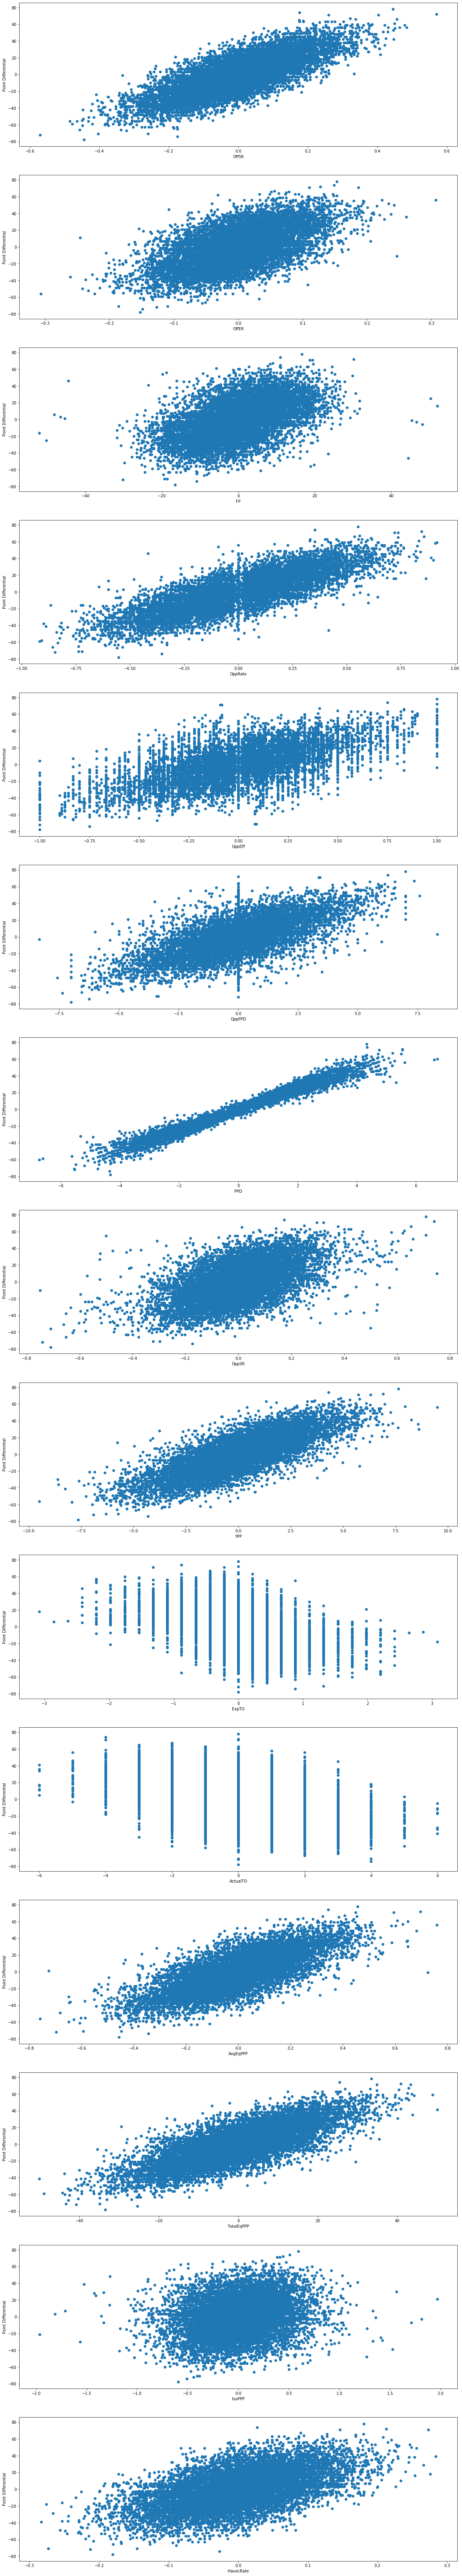

In [115]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

for i in range(len(inputs)):
    inpt = inputs[i]
    axes[i].scatter(stored_game_boxes[f"{inpt}Diff"], stored_game_boxes.PtsDiff);
    axes[i].set_xlabel(inpt)
    axes[i].set_ylabel("Point Differential");

In [88]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,0,0,0,0,UCF,2012,322432006,56.0,42.0,0.796214,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.192499,1.015913,1.008803,1.907384
1,1,1,1,1,Akron,2012,322432006,14.0,-42.0,0.203786,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.307501,-1.015913,1.008803,1.907384
2,2,2,2,0,South Carolina,2012,322430238,17.0,4.0,0.518995,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,4.892597,-0.212660,0.211171,0.181656
3,3,3,3,1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.607403,0.212660,0.211171,0.181656
4,4,4,4,0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.509808,-0.807733,0.802080,0.499553


In [89]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3.2)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.2)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [90]:
# outliers

In [91]:
train_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,0,0,0,0,UCF,2012,322432006,56.0,42.0,0.796214,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.192499,1.015913,1.008803,1.907384
1,1,1,1,1,Akron,2012,322432006,14.0,-42.0,0.203786,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.307501,-1.015913,1.008803,1.907384
2,2,2,2,0,South Carolina,2012,322430238,17.0,4.0,0.518995,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,4.892597,-0.212660,0.211171,0.181656
3,3,3,3,1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.607403,0.212660,0.211171,0.181656
4,4,4,4,0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.509808,-0.807733,0.802080,0.499553


In [92]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

In [94]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

test.corr()
print(f'R-squared: {model.score(train_data["5FRDiff"][:,np.newaxis], train_data.PtsDiff)}\n')
# print(f'Linear Regression Model:\nPtsDiff = {model.intercept_:.5f}')
# for i in range(len(inputDiffs)):
#     inptDf = inputDiffs[i]
#     print(f"+ ({model.coef_[i]:.5f} * {inptDf})")
    
test.corr()

Linear Regression: y = 20.08278x + 0.03131
Mean Pred Score: 0.6846544720974861
Pred Std Dev: 19.94772842406448
MAPE: 253.85406990361082%
Mean Abs Error: 6.697223432924136
Mdn Abs Error: 5.371726821137708
R-squared: 0.8421693525533639



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.762675,0.547586,0.497380,0.799722,0.580566,0.587540,0.982475,0.518245,0.777517,-0.460438,-0.465611,0.722191,0.753175,0.206925,0.545097,0.905902,0.918717,0.918717
OffSRDiff,0.762675,1.000000,0.449756,0.287835,0.697109,0.368691,0.427807,0.760067,0.744707,0.717449,-0.319527,-0.186989,0.619037,0.750760,-0.107338,0.547510,0.886902,0.801147,0.801147
OffERDiff,0.547586,0.449756,1.000000,0.154099,0.483675,0.282077,0.303947,0.531507,0.322227,0.793465,-0.190952,-0.112679,0.751540,0.605693,0.562880,0.197003,0.525293,0.535944,0.535944
FPDiff,0.497380,0.287835,0.154099,1.000000,0.603978,0.099706,0.086606,0.473336,0.061179,0.241309,-0.288432,-0.384845,0.239969,0.235644,0.027664,0.263701,0.585023,0.642289,0.642289
OppRateDiff,0.799722,0.697109,0.483675,0.603978,1.000000,0.185059,0.186098,0.798175,0.283185,0.673564,-0.318434,-0.329775,0.591760,0.737468,0.107180,0.514406,0.829424,0.901176,0.901176
OppEffDiff,0.580566,0.368691,0.282077,0.099706,0.185059,1.000000,0.737155,0.577503,0.487490,0.420423,-0.275395,-0.312631,0.398319,0.342562,0.171365,0.304831,0.471266,0.446421,0.446421
OppPPDDiff,0.587540,0.427807,0.303947,0.086606,0.186098,0.737155,1.000000,0.593870,0.556009,0.459763,-0.309681,-0.294540,0.443846,0.363469,0.164895,0.332624,0.538530,0.512037,0.512037
PPDDiff,0.982475,0.760067,0.531507,0.473336,0.798175,0.577503,0.593870,1.000000,0.514378,0.762120,-0.450488,-0.459779,0.706658,0.729468,0.191296,0.552475,0.897005,0.911739,0.911739
OppSRDiff,0.518245,0.744707,0.322227,0.061179,0.283185,0.487490,0.556009,0.514378,1.000000,0.529824,-0.262907,-0.125711,0.471970,0.455074,-0.059455,0.371281,0.646122,0.538235,0.538235
YPPDiff,0.777517,0.717449,0.793465,0.241309,0.673564,0.420423,0.459763,0.762120,0.529824,1.000000,-0.345468,-0.224663,0.909716,0.803360,0.486712,0.465872,0.773437,0.764271,0.764271


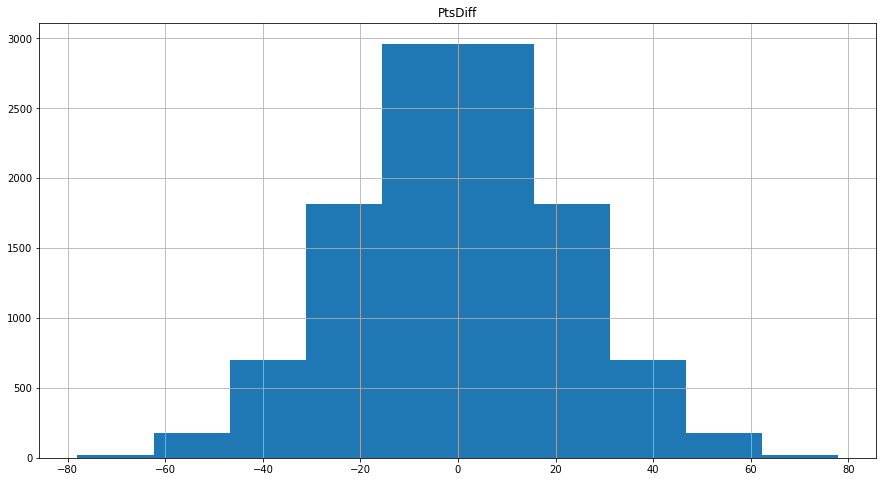

In [95]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

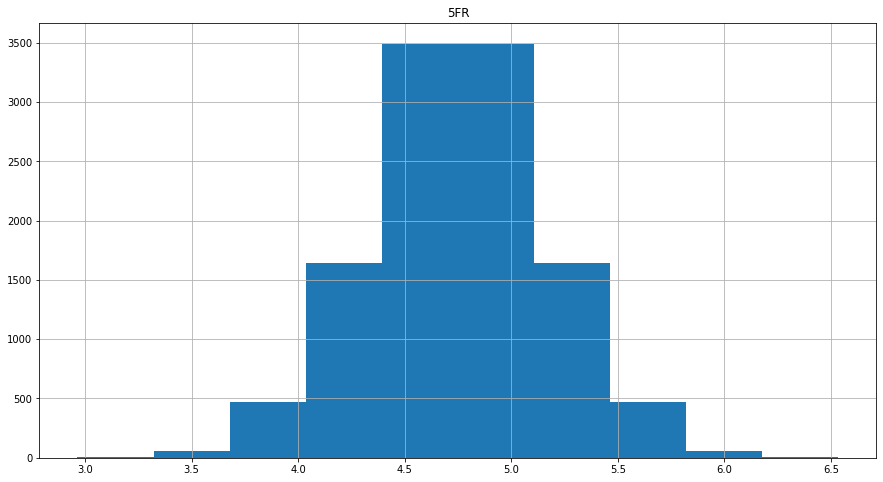

In [96]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

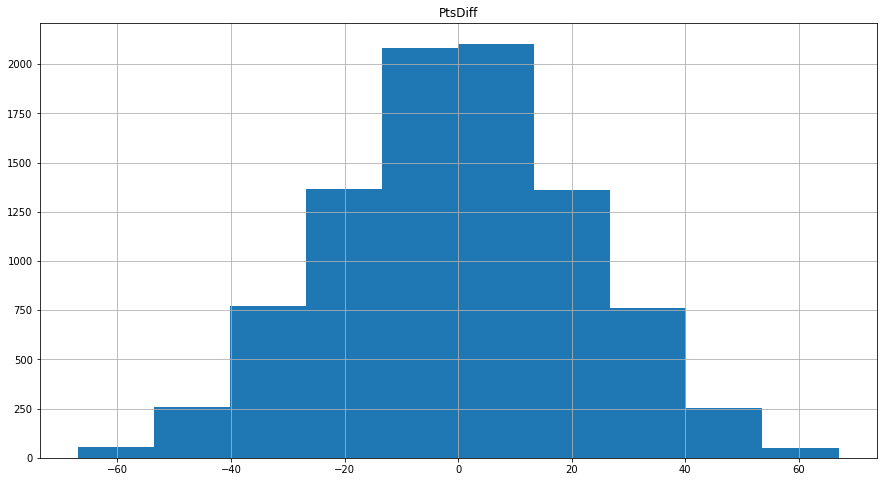

In [97]:
train_data.hist(column='PtsDiff', figsize=(15,8));

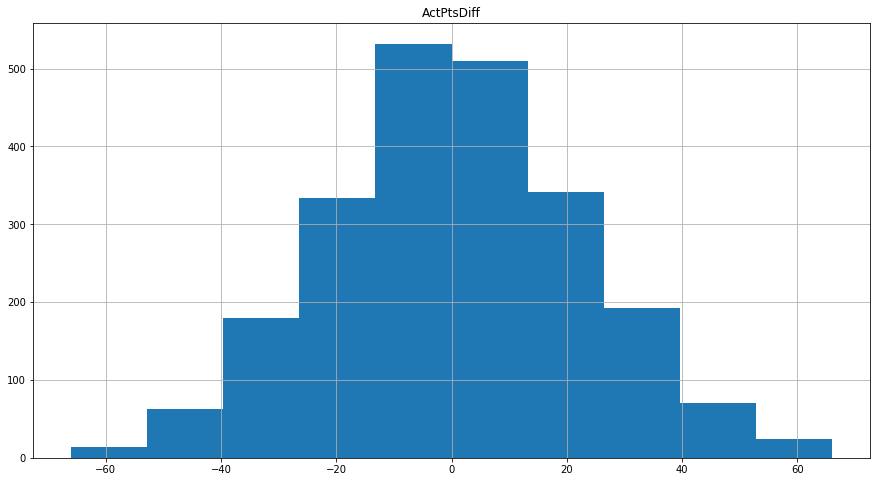

In [98]:
test.hist(column='ActPtsDiff', figsize=(15,8));

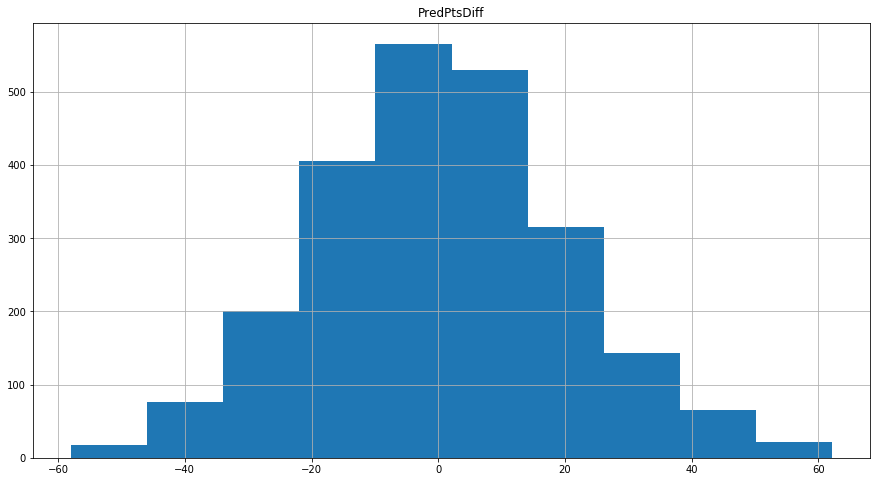

In [38]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [99]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")
    print("---")
    return stats.norm.cdf(z)

In [100]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -3.0 (exact value: -3.33759892524249)
Z score: -0.20163967103580688
Win Prob for Virginia Tech: 42.01%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,4.833875,0.167751
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.666125,-0.167751


In [101]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -12.0 (exact value: -12.242636461086171)
Z score: -0.6480582980861356
Win Prob for Georgia Tech: 25.85%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,0.07619,-0.330005,-0.66,1,-0.014422,-0.482035,-0.121075,0.018689,4.444416,-0.611168
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,-0.07619,0.330005,0.66,-1,0.014422,0.482035,0.121075,-0.018689,5.055584,0.611168


In [102]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -1.0 (exact value: -0.834585818423882)
Z score: -0.07616106747716657
Win Prob for Georgia Tech: 46.96%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.01919,-1.322588,0.0,-2,-0.129463,1.273286,-0.300725,0.012719,4.771558,0.043116
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.01919,1.322588,0.0,2,0.129463,-1.273286,0.300725,-0.012719,4.728442,-0.043116


In [103]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 3.0 (exact value: 3.1987392525075746)
Z score: 0.1260336378641066
Win Prob for Mississippi State: 55.01%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,0.880173,...,-0.059649,0.080622,0.22,1,0.020976,6.298842,0.092249,0.000243,4.671141,-0.157719
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,0.059649,-0.080622,-0.22,-1,-0.020976,-6.298842,-0.092249,-0.000243,4.828859,0.157719


In [104]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -4.0 (exact value: -3.998004226417308)
Z score: -0.23474646330485144
Win Prob for Texas A&M: 40.72%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,0.014666,0.876496,0.0,-1,-0.103285,-15.374294,-0.349878,0.001282,4.850318,0.200635
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,-0.014666,-0.876496,0.0,1,0.103285,15.374294,0.349878,-0.001282,4.649682,-0.200635


In [105]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    return stats.norm.cdf(z)

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Clemson,0.937868,13,12.0,1.0
2,Ohio State,0.936169,13,12.0,1.0
3,Alabama,0.915153,12,11.0,1.0
4,LSU,0.887407,13,12.0,1.0
5,Utah,0.847574,13,11.0,2.0
6,Oregon,0.839018,13,11.0,2.0
7,Wisconsin,0.833273,13,11.0,2.0
8,Notre Dame,0.811203,12,10.0,2.0
9,Georgia,0.805806,13,10.0,3.0
10,Oklahoma,0.781004,13,10.0,3.0


In [106]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.476905,1.523095
21,Clemson,10.710539,2.289461
53,LSU,10.084041,2.915959
115,Utah,9.312758,3.687242
2,Alabama,9.290928,2.709072
128,Wisconsin,9.080056,3.919944
82,Oregon,8.894976,4.105024
75,Notre Dame,8.740208,3.259792
34,Georgia,8.733538,4.266462
78,Oklahoma,8.710579,4.289421


In [107]:
# Matchup Predictor?
def predict_matchup(team1, team2, year):
    team1_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team1) & (stored_game_boxes.Season == year)]['5FR'][-4:].mean()
    team2_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team2) & (stored_game_boxes.Season == year)]['5FR'][-4:].mean()
    if (~(teams[teams.school == team1].conference.isin(p5).all())):
        team1_avg_ffr *= 0.85 # arbitrary
    if (~(teams[teams.school == team2].conference.isin(p5).all())):
        team2_avg_ffr *= 0.85 # arbitrary
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019)

[0.06350056700129689, -29.756278412324882]

In [108]:
team_triples = [
    ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl
    ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl
    ['Penn State','Memphis',7], # Cotton Bowl
    ['Florida','Virginia',14], # Orange Bowl
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5] # Sugar Bowl
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Clemson,Ohio State,2.5,10.403401,0.686945,True,Clemson,Clemson
0,Penn State,Memphis,7.0,8.728594,0.656618,True,Penn State,Penn State
0,Florida,Virginia,14.0,7.853839,0.640352,False,Florida,Virginia
0,LSU,Oklahoma,11.0,7.267043,0.629293,False,LSU,Oklahoma
0,Wisconsin,Oregon,2.5,-2.544606,0.435698,False,Oregon,Oregon
0,Georgia,Baylor,7.5,-3.516178,0.416603,False,Baylor,Baylor


In [109]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 3.0 (exact value: 2.5162804405494583)
Z score: 0.09182128057460122
Win Prob for Virginia: 53.66%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,0.073684,-2.332187,0.66,3,-0.135068,2.373916,-0.403644,-0.089435,4.688132,-0.123737
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,-0.073684,2.332187,-0.66,-3,0.135068,-2.373916,0.403644,0.089435,4.811868,0.123737


In [110]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 8.0 (exact value: 7.743875676633906)
Z score: 0.3538859690921167
Win Prob for North Carolina: 63.83%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.123887,-0.349659,0.0,-1,-0.01403,15.633715,-0.235394,0.079888,4.94202,0.384039
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.123887,0.349659,0.0,1,0.01403,-15.633715,0.235394,-0.079888,4.55798,-0.384039


In [111]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 13.0 (exact value: 13.499806730943547)
Z score: 0.6424366718060066
Win Prob for Pittsburgh: 73.97%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,0.20743,1.49512,0.0,1,0.130501,14.249196,-0.248736,0.038746,5.085325,0.670649
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,-0.20743,-1.49512,0.0,-1,-0.130501,-14.249196,0.248736,-0.038746,4.414675,-0.670649


In [112]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -8.0 (exact value: -7.7683924640341395)
Z score: -0.4237598766350792
Win Prob for Auburn: 33.59%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,0.114729,1.117419,0.44,1,0.063274,9.532495,-0.083465,-0.033763,4.944189,0.388377
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,-0.114729,-1.117419,-0.44,-1,-0.063274,-9.532495,0.083465,0.033763,4.555811,-0.388377


In [113]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 29.0 (exact value: 28.558508768422897)
Z score: 1.3973447855194898
Win Prob for Georgia: 91.88%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,-0.047059,4.45067,0.0,2,0.330151,25.998278,0.455922,0.020115,5.460241,1.420481
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,0.047059,-4.45067,0.0,-2,-0.330151,-25.998278,-0.455922,-0.020115,4.039759,-1.420481


In [114]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row):
    prob = generate_win_prob(row.GameID, 2019)
    return prob if row.ActualMOV > 0 else 1-prob

def retrieve_win_probs(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame({"GameID":game_ids,"Year":year})
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x) * 100, axis=1)
    return frame

retrieve_win_probs("Georgia Tech", 2019)

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 18.0 (exact value: 17.7380223423604)
Z score: 0.8549027492117912
Win Prob for Clemson: 80.37%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 5.0 (exact value: 4.838063537404658)
Z score: 0.20821463863006046
Win Prob for Georgia Tech: 58.25%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -14.0 (exact value: -13.778846648286407)
Z score: -0.725070083816434
Win Prob for The Citadel: 23.42%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 17.0 (exact value: 17.044458486929507)
Z score: 0.820133684750587
Win Prob for Temple: 79.39%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 8.0 (exact value: 7.743875676633906)
Z score: 0.3538859690921167


,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
5804,401111653,2019,Georgia Tech,Clemson,-38.0,19.630249
5900,401112441,2019,Georgia Tech,South Florida,4.0,58.246931
5967,401112452,2019,Georgia Tech,The Citadel,-3.0,76.579548
6107,401112469,2019,Georgia Tech,Temple,-22.0,20.606995
6164,401112475,2019,Georgia Tech,North Carolina,-16.0,36.171217
6198,401112480,2019,Georgia Tech,Duke,-18.0,34.312192
6251,401112488,2019,Georgia Tech,Miami,7.0,25.847362
6384,401112498,2019,Georgia Tech,Pittsburgh,-10.0,26.029485
6418,401112504,2019,Georgia Tech,Virginia,-5.0,31.414495
6475,401112511,2019,Georgia Tech,Virginia Tech,-45.0,0.433578


In [ ]:
# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)